In [ ]:
# install libraries
!pip install yfinance
!pip install ta
!pip install stable.baselines3
!pip install 'shimmy>=0.2.1'

# import standard libraries
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import t, skew, kurtosis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras import callbacks
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
%matplotlib inline
import datetime
import ta
warnings.filterwarnings("ignore")

import gym
from gym import spaces
from gym.utils import seeding

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.policies import ActorCriticPolicy #MlpPolicy for A2C and PPO
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import ActionNoise, OrnsteinUhlenbeckActionNoise

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
# list of stocks to be analyzed
stocks = ['AZN.L', 'BP.L', 'HSBA.L', 'RIO.L', 'SHEL.L', 'ULVR.L']

# set time period for historical data
start_date = '2012-01-01'
end_date = '2023-03-31'

# Create an empty DataFrame
df_stock = pd.DataFrame()

# Iterate over the list of stocks and append them to the DataFrame
for stock in stocks:
    # Download historical data from Yahoo Finance for each stock
    data = yf.download(stock, start=start_date, end=end_date)

    # Add a column to identify the stock
    data['Stock'] = stock

    # Append the data for the stock to the DataFrame
    df_stock = df_stock.append(data)

# check the first 5 rows of the dataframe
df_stock.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock
Date,,,,,,,
2012-01-03,3018.0,3050.000000,2984.0,3050.0,1908.954834,3453871,AZN.L
2012-01-04,3059.0,3069.126953,3017.0,3034.5,1899.253662,2719930,AZN.L
2012-01-05,3010.0,3030.129883,2992.0,3009.5,1883.606079,3022255,AZN.L
2012-01-06,3014.5,3042.500000,3009.5,3042.5,1904.260254,2098457,AZN.L
2012-01-09,3049.5,3049.500000,3003.0,3009.0,1883.292969,2654630,AZN.L


# T-distribution Plot

In [ ]:
# define a function that plot a T distribution of the stock data
def T_distribution_plot(stock, ax):
    """This plots t-distribution using the returns of each stocks"""
    returns = df_stock[df_stock['Stock'] == stock]['Adj Close'].pct_change().dropna()

    x_list = np.linspace(returns.min(), returns.max(), 100)
    params = t.fit(returns)
    df, loc, scale = params
    y_list = t.pdf(x_list, df, loc, scale)

    ax.plot(x_list, y_list, label='T Dist')
    ax.hist(returns, bins=100, density=True, alpha=0.5, label=f'{stock} Returns')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'T Distribution of Returns for {stock}')
    ax.legend(bbox_to_anchor=(1.0, 1.0))

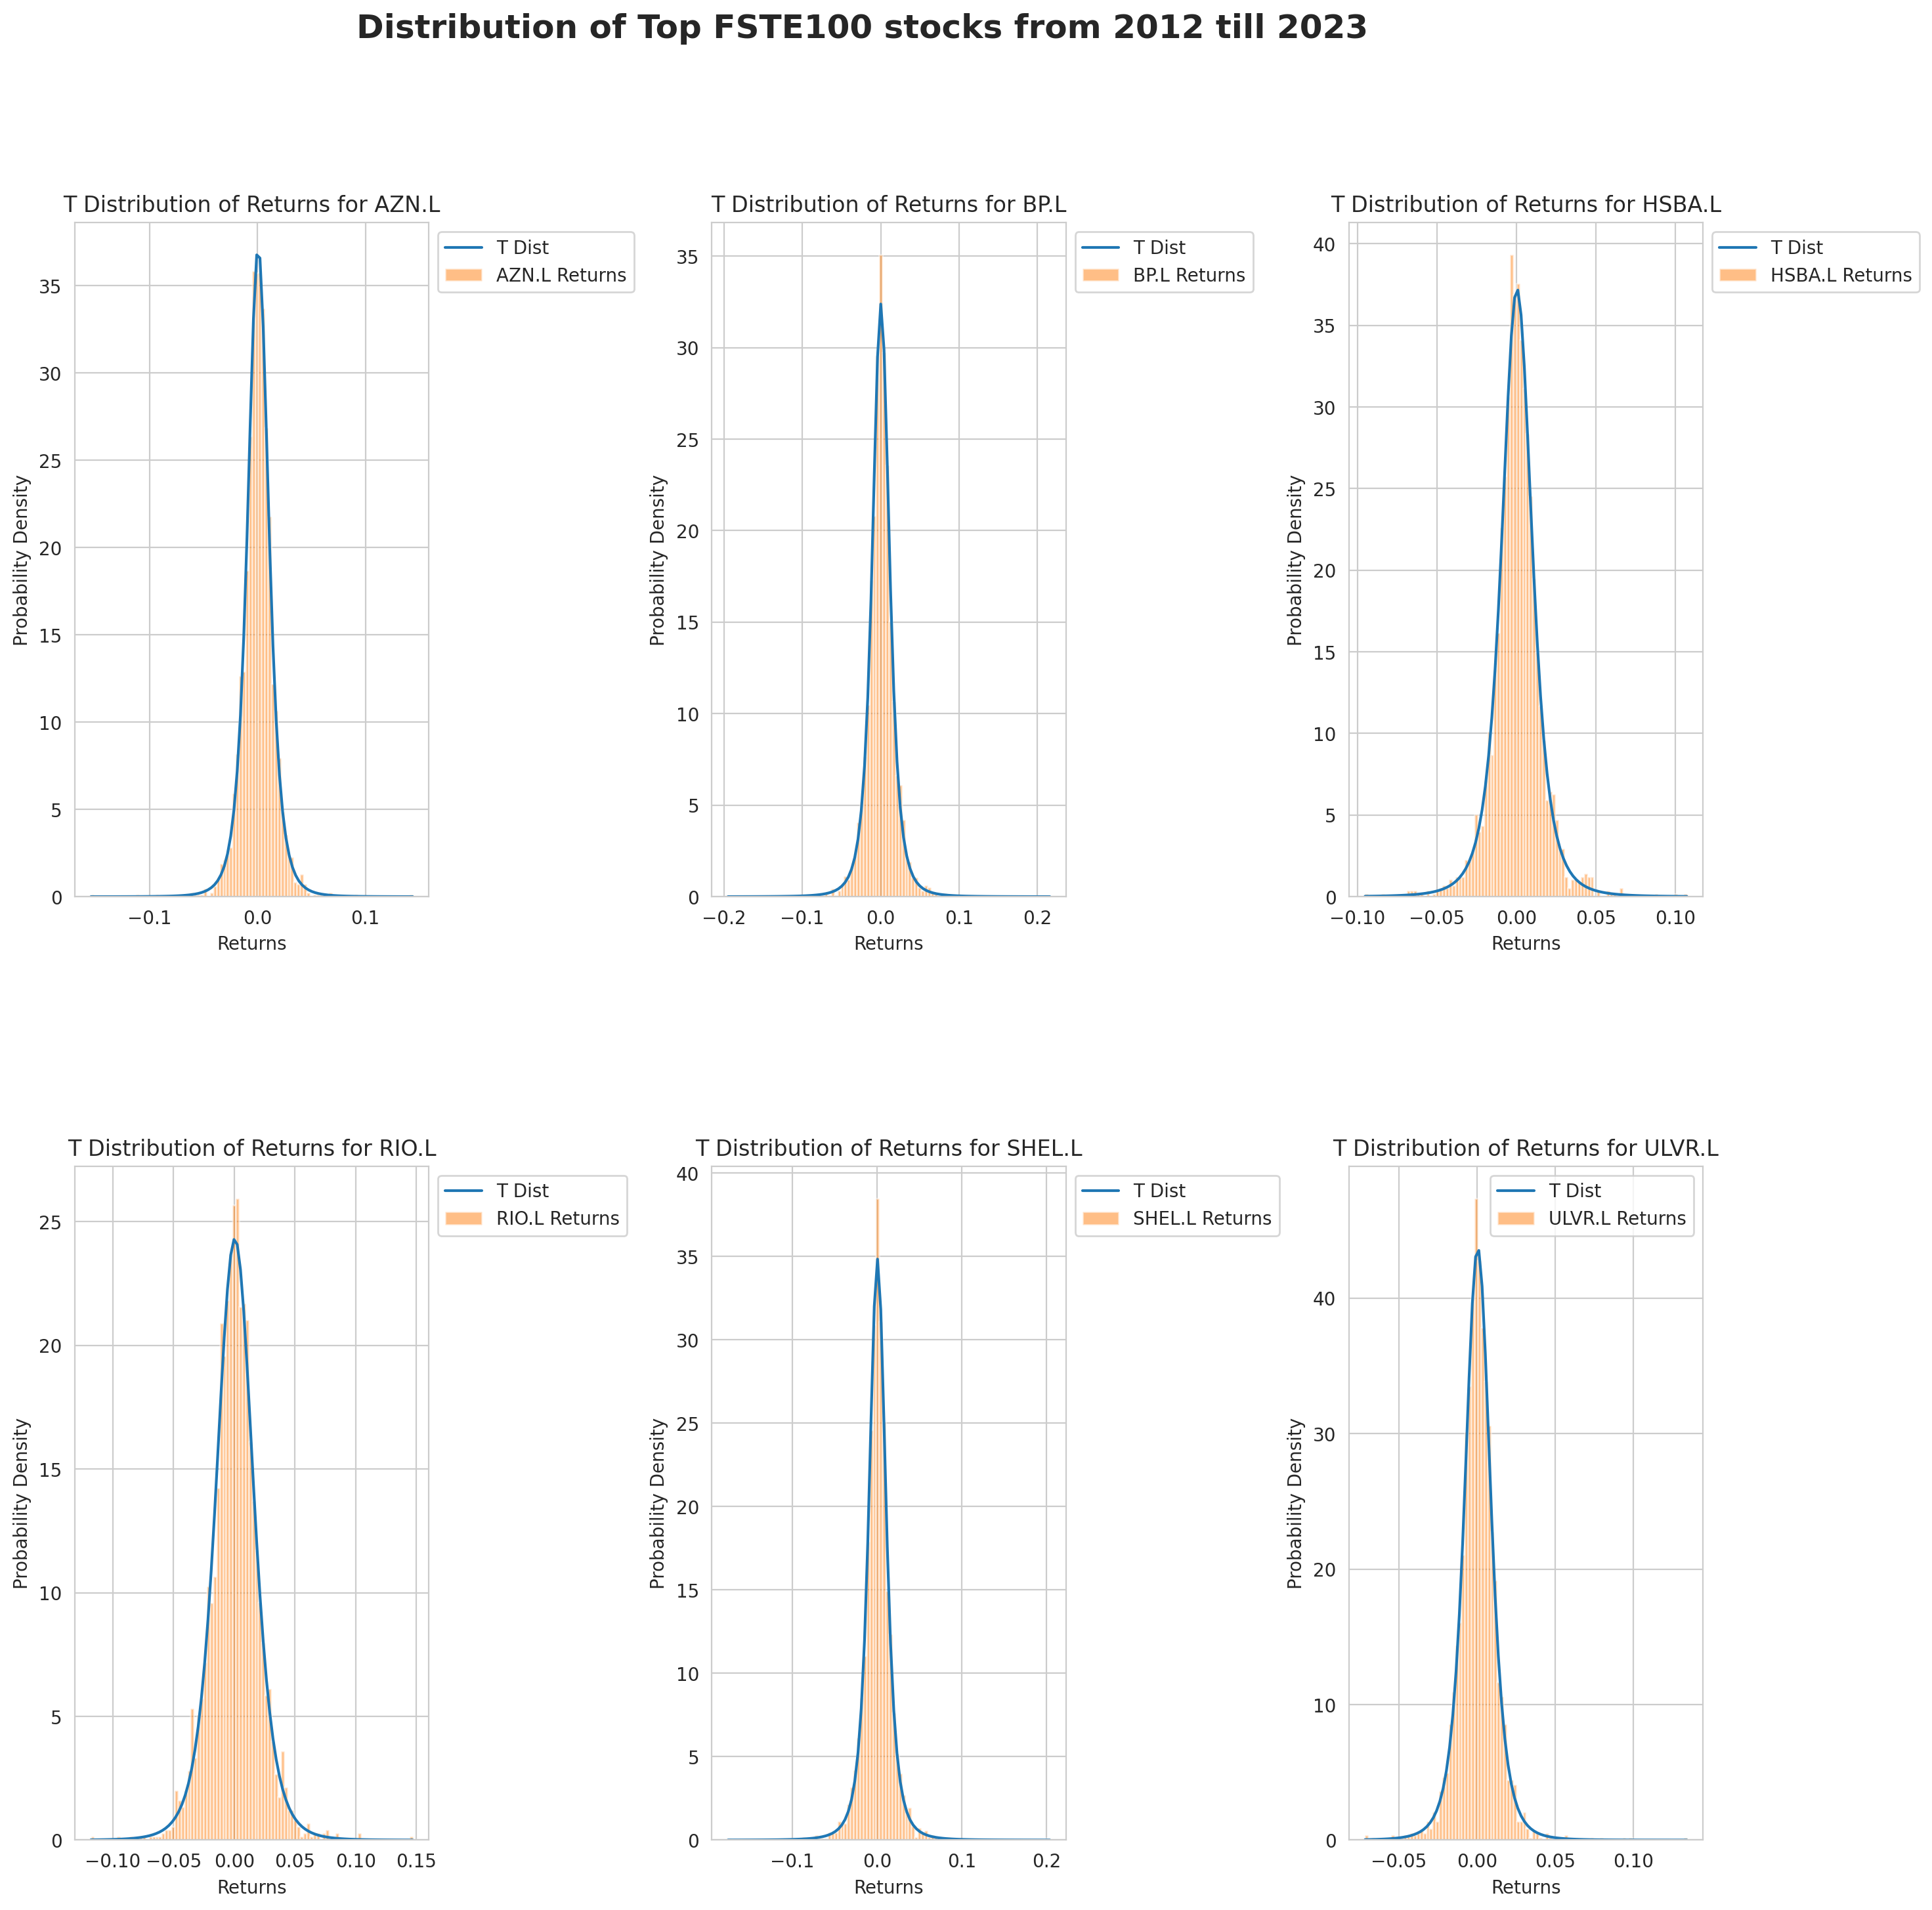

In [ ]:
# create a gridspec with rows 2 and 3 columns for distribution of the stocks
fig = plt.figure(figsize=(16,16), dpi=200)
fig.suptitle('Distribution of Top FSTE100 stocks from 2012 till 2023', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.8, hspace=0.4)

# Plot distribution for AZN
ax1 = plt.subplot(gs[0,0])
T_distribution_plot('AZN.L', ax=ax1)

# Plot distribution for BP
ax2 = plt.subplot(gs[0,1])
T_distribution_plot('BP.L', ax=ax2)

# Plot distribution for HSBA
ax3 = plt.subplot(gs[0,2])
T_distribution_plot('HSBA.L', ax=ax3)

# Plot distribution for RIO
ax4 = plt.subplot(gs[1,0])
T_distribution_plot('RIO.L', ax=ax4)

# Plot distribution for SHELL
ax5 = plt.subplot(gs[1,1])
T_distribution_plot('SHEL.L', ax=ax5)

# Plot distribution for ULVR
ax6 = plt.subplot(gs[1,2])
T_distribution_plot('ULVR.L', ax=ax6)

plt.show()

# Skewness and Kurtosis

In [ ]:
# the returns dataframe is used to calculate the skewness and kurtosis of each stock
# create dataframe stock name in the 'stock' column
df_stock_names = pd.DataFrame({'Stock': ['AZN.L', 'BP.L', 'HSBA.L', 'RIO.L', 'SHEL.L', 'ULVR.L']})

# Empty DataFrame to store returns
df_returns = pd.DataFrame()
# Loop through stock names and calculate returns
for stock in df_stock_names['Stock']:
  returns = df_stock[df_stock['Stock'] == stock]['Adj Close'].pct_change()
  # Add returns to the DataFrame
  df_returns[stock] = returns

# check the first 5 rows of the stock returns dataframe
df_returns.head()

,AZN.L,BP.L,HSBA.L,RIO.L,SHEL.L,ULVR.L
Date,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,-0.005082,0.005095,-0.009705,0.005113,-0.004201,-0.015076
2012-01-05,-0.008238,0.001267,-0.004800,-0.006284,-0.008439,0.006494
2012-01-06,0.010965,0.006328,0.001206,-0.002259,0.014893,-0.021659
2012-01-09,-0.011011,-0.007232,-0.013649,-0.000754,-0.000419,0.005652


In [ ]:
# a function the calculate skewness and kurtosis
def calculate_skewness_and_kurtosis(data):
    """This calculates the skewness and kurtosis of each stock returns and also appends the result to a dataframe called results"""
    # Create an empty DataFrame to store the results
    results = pd.DataFrame(index=df_returns.columns, columns=['Skewness', 'Kurtosis'])

    # Iterate over each stock
    for stock in df_returns.columns:
        # Calculate the skewness and kurtosis
        skewness = round(skew(df_returns[stock].dropna()), 2)
        kurt = round(kurtosis(df_returns[stock].dropna()), 2)

        # Store the results in the DataFrame
        results.loc[stock, 'Skewness'] = skewness
        results.loc[stock, 'Kurtosis'] = kurt

    return results

# pass the returns dataframe to the calculate skewness and kurtosis function
calculate_skewness_and_kurtosis(data=df_returns)

,Skewness,Kurtosis
AZN.L,-0.07,11.68
BP.L,0.23,15.62
HSBA.L,0.1,4.99
RIO.L,0.17,3.01
SHEL.L,-0.06,15.51
ULVR.L,0.61,10.48


In [ ]:
# reset the index of df_stock dataframe
df_stock.reset_index(inplace=True)

df = df_stock.copy()
# Dropping other columns except Adj Close Column
df = df.drop(['Close', 'Open', 'High', 'Low', 'Volume'], 1)
df = df.rename(columns={'Adj Close':'AdjClose'})
df = df.sort_values(by= ['Date', 'Stock'])
df = df.pivot(index= 'Date', columns= 'Stock')
df = df.droplevel(0, axis=1)
df = df.fillna(0)

# Correlation Heatmap

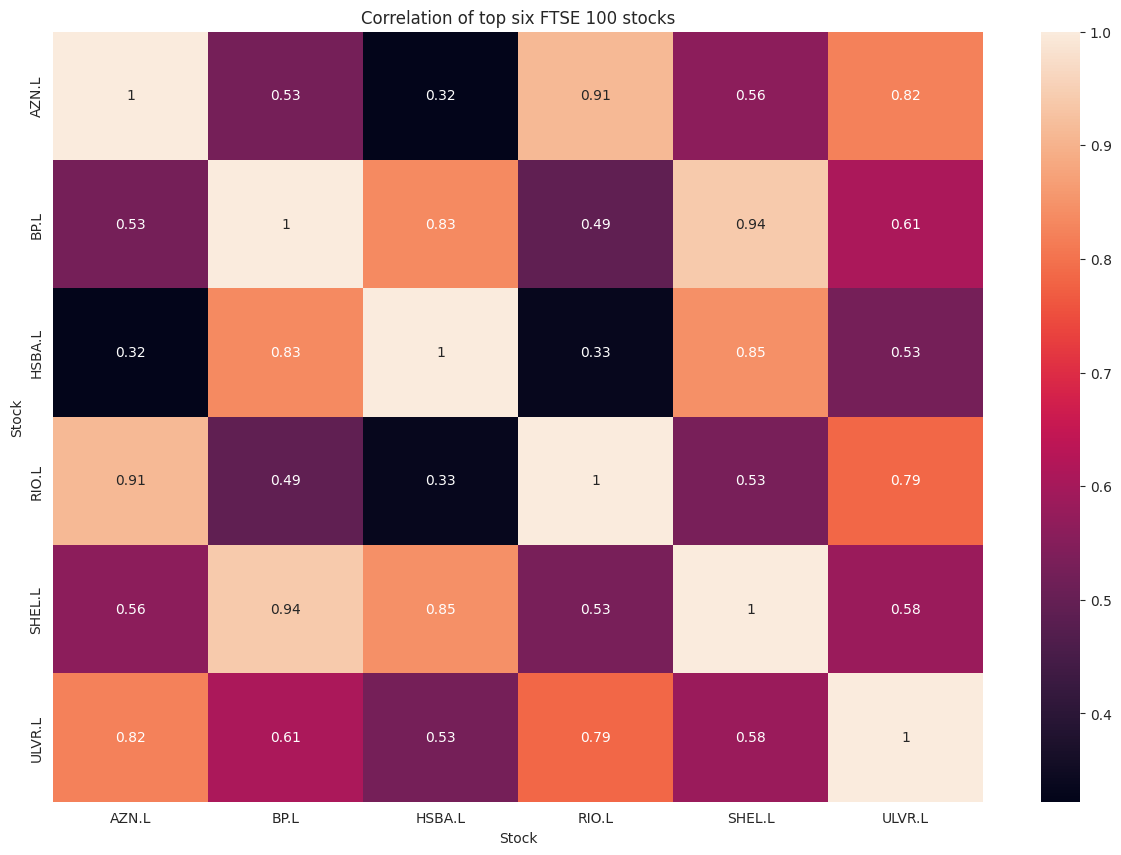

In [ ]:
# create an correlation heatmap of df dataframe
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation of top six FTSE 100 stocks')
plt.show()

# Moving Averages Plot

In [ ]:
# define a function that plots the moving averages of the stock
def moving_averages_plot(df, stock, ax):
    """This plots the adjusted close prices along side with the slow and fast moving averages of the prices"""
    df[stock].plot(label=f"stock Adj Close")
    df[stock].rolling(window=63).mean().plot(label='Quarterly Moving Avg')
    df[stock].rolling(window=252).mean().plot(label='Yearly Moving Avg')
    ax.set_title(f'Adjusted Close Price vs Moving Averages of {stock}', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Stock Price [£]', fontsize=12)
    ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=10)


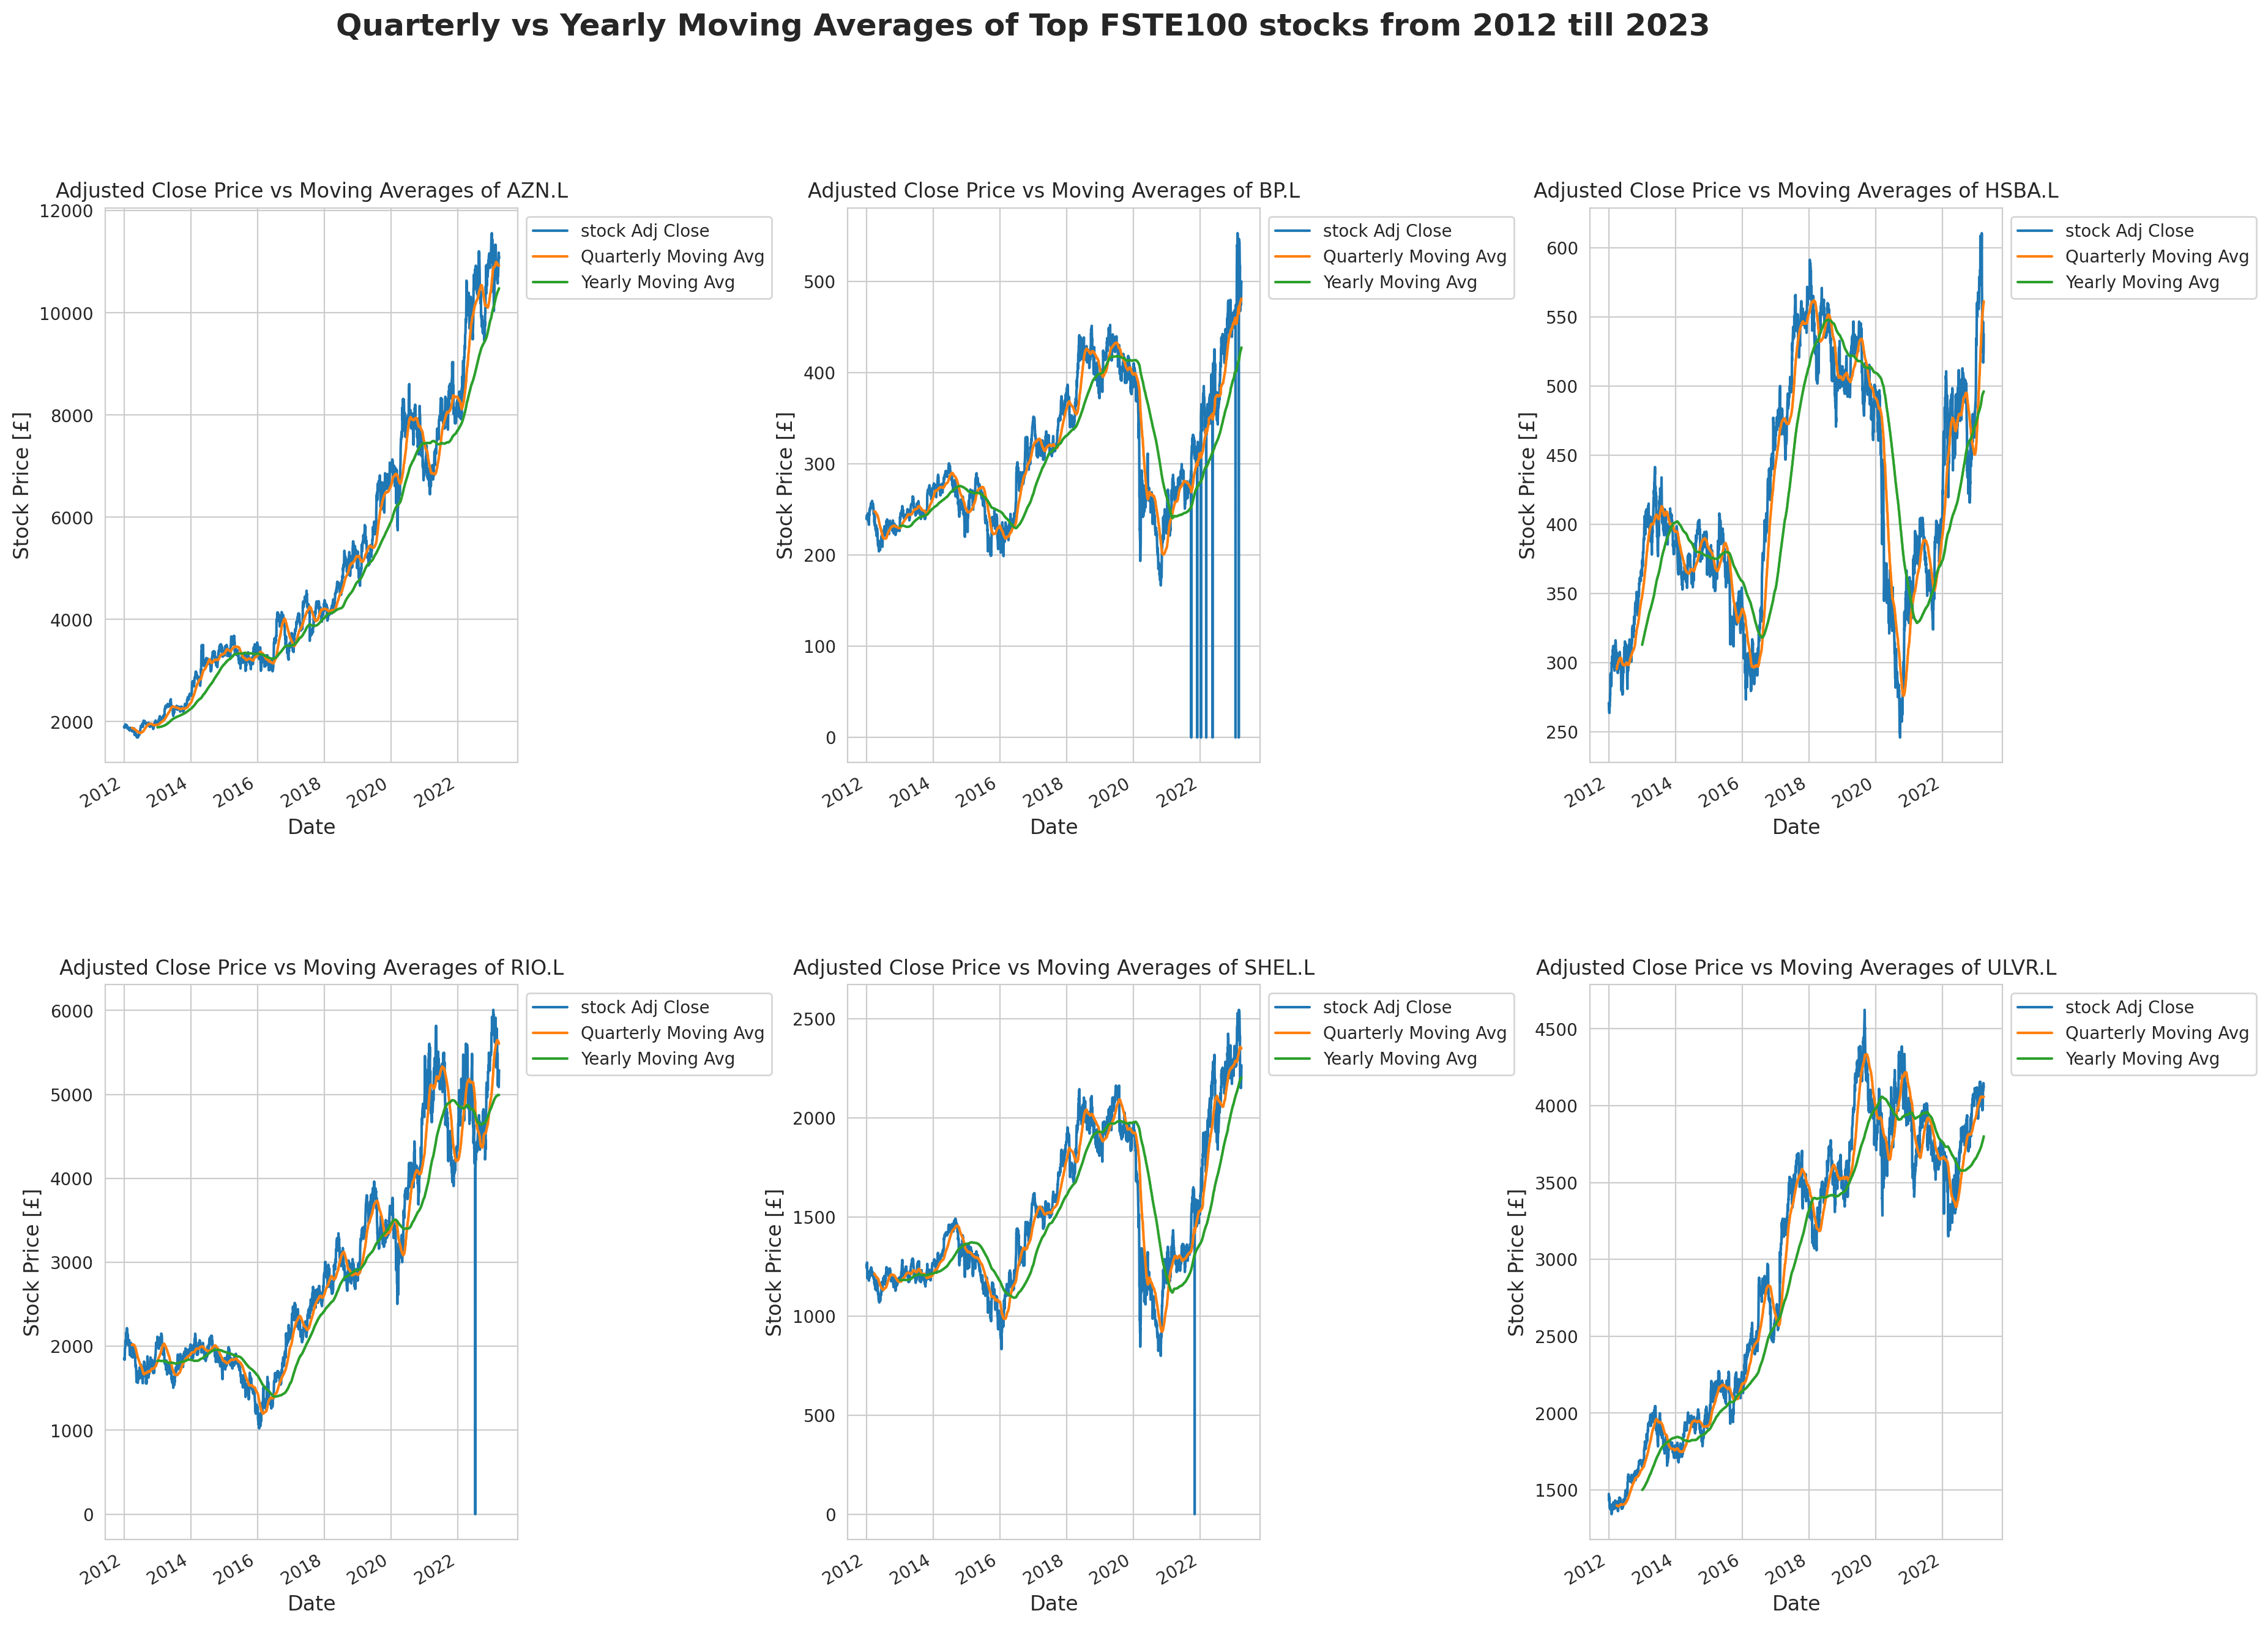

In [ ]:
# create a gridspec with rows 2 and 3 columns for Simple moving Averages plot
fig = plt.figure(figsize=(20,16), dpi=200)
fig.suptitle('Quarterly vs Yearly Moving Averages of Top FSTE100 stocks from 2012 till 2023', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.8, hspace=0.4)

# Plot for AZN
ax1 = plt.subplot(gs[0,0])
moving_averages_plot(df, 'AZN.L', ax=ax1)

# Plot for BP
ax2 = plt.subplot(gs[0,1])
moving_averages_plot(df, 'BP.L', ax=ax2)

# Plot for HSBA
ax3 = plt.subplot(gs[0,2])
moving_averages_plot(df, 'HSBA.L', ax=ax3)

# Plot for RIO
ax4 = plt.subplot(gs[1,0])
moving_averages_plot(df, 'RIO.L', ax=ax4)

# Plot for SHELL
ax5 = plt.subplot(gs[1,1])
moving_averages_plot(df, 'SHEL.L', ax=ax5)

# Plot for ULVR
ax6 = plt.subplot(gs[1,2])
moving_averages_plot(df, 'ULVR.L', ax=ax6)

plt.show()

# Traditional trading method: Simple Moving Average Strategy

In [ ]:
# generate buy and sell signals
def get_buy_sell_signals(data):
    """This generates a buy and sell signal using 2 simple moving average windows"""
    # Calculate simple moving averages (SMA)
    data['fastSMA'] = data['Adj Close'].rolling(window=15).mean()
    data['slowSMA'] = data['Adj Close'].rolling(window=60).mean()

    # Define buy/sell signals
    data['Buy'] = (data['fastSMA'] > data['slowSMA']).astype(int)
    data['Sell'] = (data['fastSMA'] < data['slowSMA']).astype(int)

    return data

# a function that downloads stock and splits it based on train and test
def analyze_stock(stock, start_date, end_date, train_end_date):
    """
    the function analyzes stock by downloading each stock data and passing the get_buy_sell_signals function into each dataframe
    the data is split into train and test data using the dates of the dataseet
    """
    # Download historical data from Yahoo Finance
    data = yf.download(stock, start=start_date, end=end_date)

    # Process data and generate buy/sell signals
    data = get_buy_sell_signals(data)

    # Split data into train and test
    train_data = data.loc[:train_end_date]
    test_data = data.loc[train_end_date:]

    return train_data, test_data

# Calculate returns based on the buy/sell signals
def calculate_returns(data):
    """
    the function derives the market position using buy and sell signal
    the returns is calculated using the adjusted closed price and the market position
    """
    data['Position'] = data['Buy'] - data['Sell']
    data['Return'] = data['Adj Close'].pct_change() * data['Position'].shift()
    return data['Return']

# calculate actual test_data cumulative returns
def actual_returns(data):
    """Calculates the original returns of the stocks dataframe and the cumulative sum"""
    data['Actual Return'] = data['Adj Close'].pct_change()
    data['Actual_cumulative_returns'] = data['Actual Return'].cumsum()
    return  data['Actual_cumulative_returns']

# Evaluate performance on train and test data
def evaluate_performance(returns):
    """Calculates the cumulative sum of returns using the returns from the market position"""
    cumulative_returns = returns.cumsum()
    return cumulative_returns

# a function that plots buy and sell signals
def plot_buy_sell_signals(data, stock, ax):
    """this plots the buy and sell signals of a particular stock using the adjusted closed price of the train dataset"""
    ax.plot(data['Adj Close'], label=stock)
    ax.plot(data.loc[data['Buy'] == 1, 'Adj Close'], '^', markersize=8, color='g', label='Buy')
    ax.plot(data.loc[data['Sell'] == 1, 'Adj Close'], 'v', markersize=8, color='r', label='Sell')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'Buy/Sell Signals - Train Data for {stock}', fontsize=12)
    ax.legend()

# function that plots cumulative returns
def plot_cumulative_returns(returns, test_data, stock, ax):
    """this plots the cumulative sum of returns of the test dataset"""
    ax.plot(returns, label=stock, alpha=0.8)
    ax.plot(actual_returns(test_data), label='Actual Returns', alpha=0.4)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title(f'Cumulative Returns - Test Data for {stock}', fontsize=12)
    ax.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the stock symbols and time period
stock_AZN = 'AZN.L'
stock_BP = 'BP.L'
stock_HSBA = 'HSBA.L'
stock_RIO = 'RIO.L'
stock_SHELL = 'SHEL.L'
stock_ULVR = 'ULVR.L'

start_date = '2012-01-01'
end_date = '2023-03-31'
train_end_date = '2022-12-31'

# Analyze the stocks and obtain train and test data with buy/sell signals
# AZN
train_data_AZN, test_data_AZN = analyze_stock(stock_AZN, start_date, end_date, train_end_date)

# BP
train_data_BP, test_data_BP = analyze_stock(stock_BP, start_date, end_date, train_end_date)

# HSBA
train_data_HSBA, test_data_HSBA = analyze_stock(stock_HSBA, start_date, end_date, train_end_date)

# RIO
train_data_RIO, test_data_RIO = analyze_stock(stock_RIO, start_date, end_date, train_end_date)

# SHELL
train_data_SHELL, test_data_SHELL = analyze_stock(stock_SHELL, start_date, end_date, train_end_date)

# ULVR
train_data_ULVR, test_data_ULVR = analyze_stock(stock_ULVR, start_date, end_date, train_end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


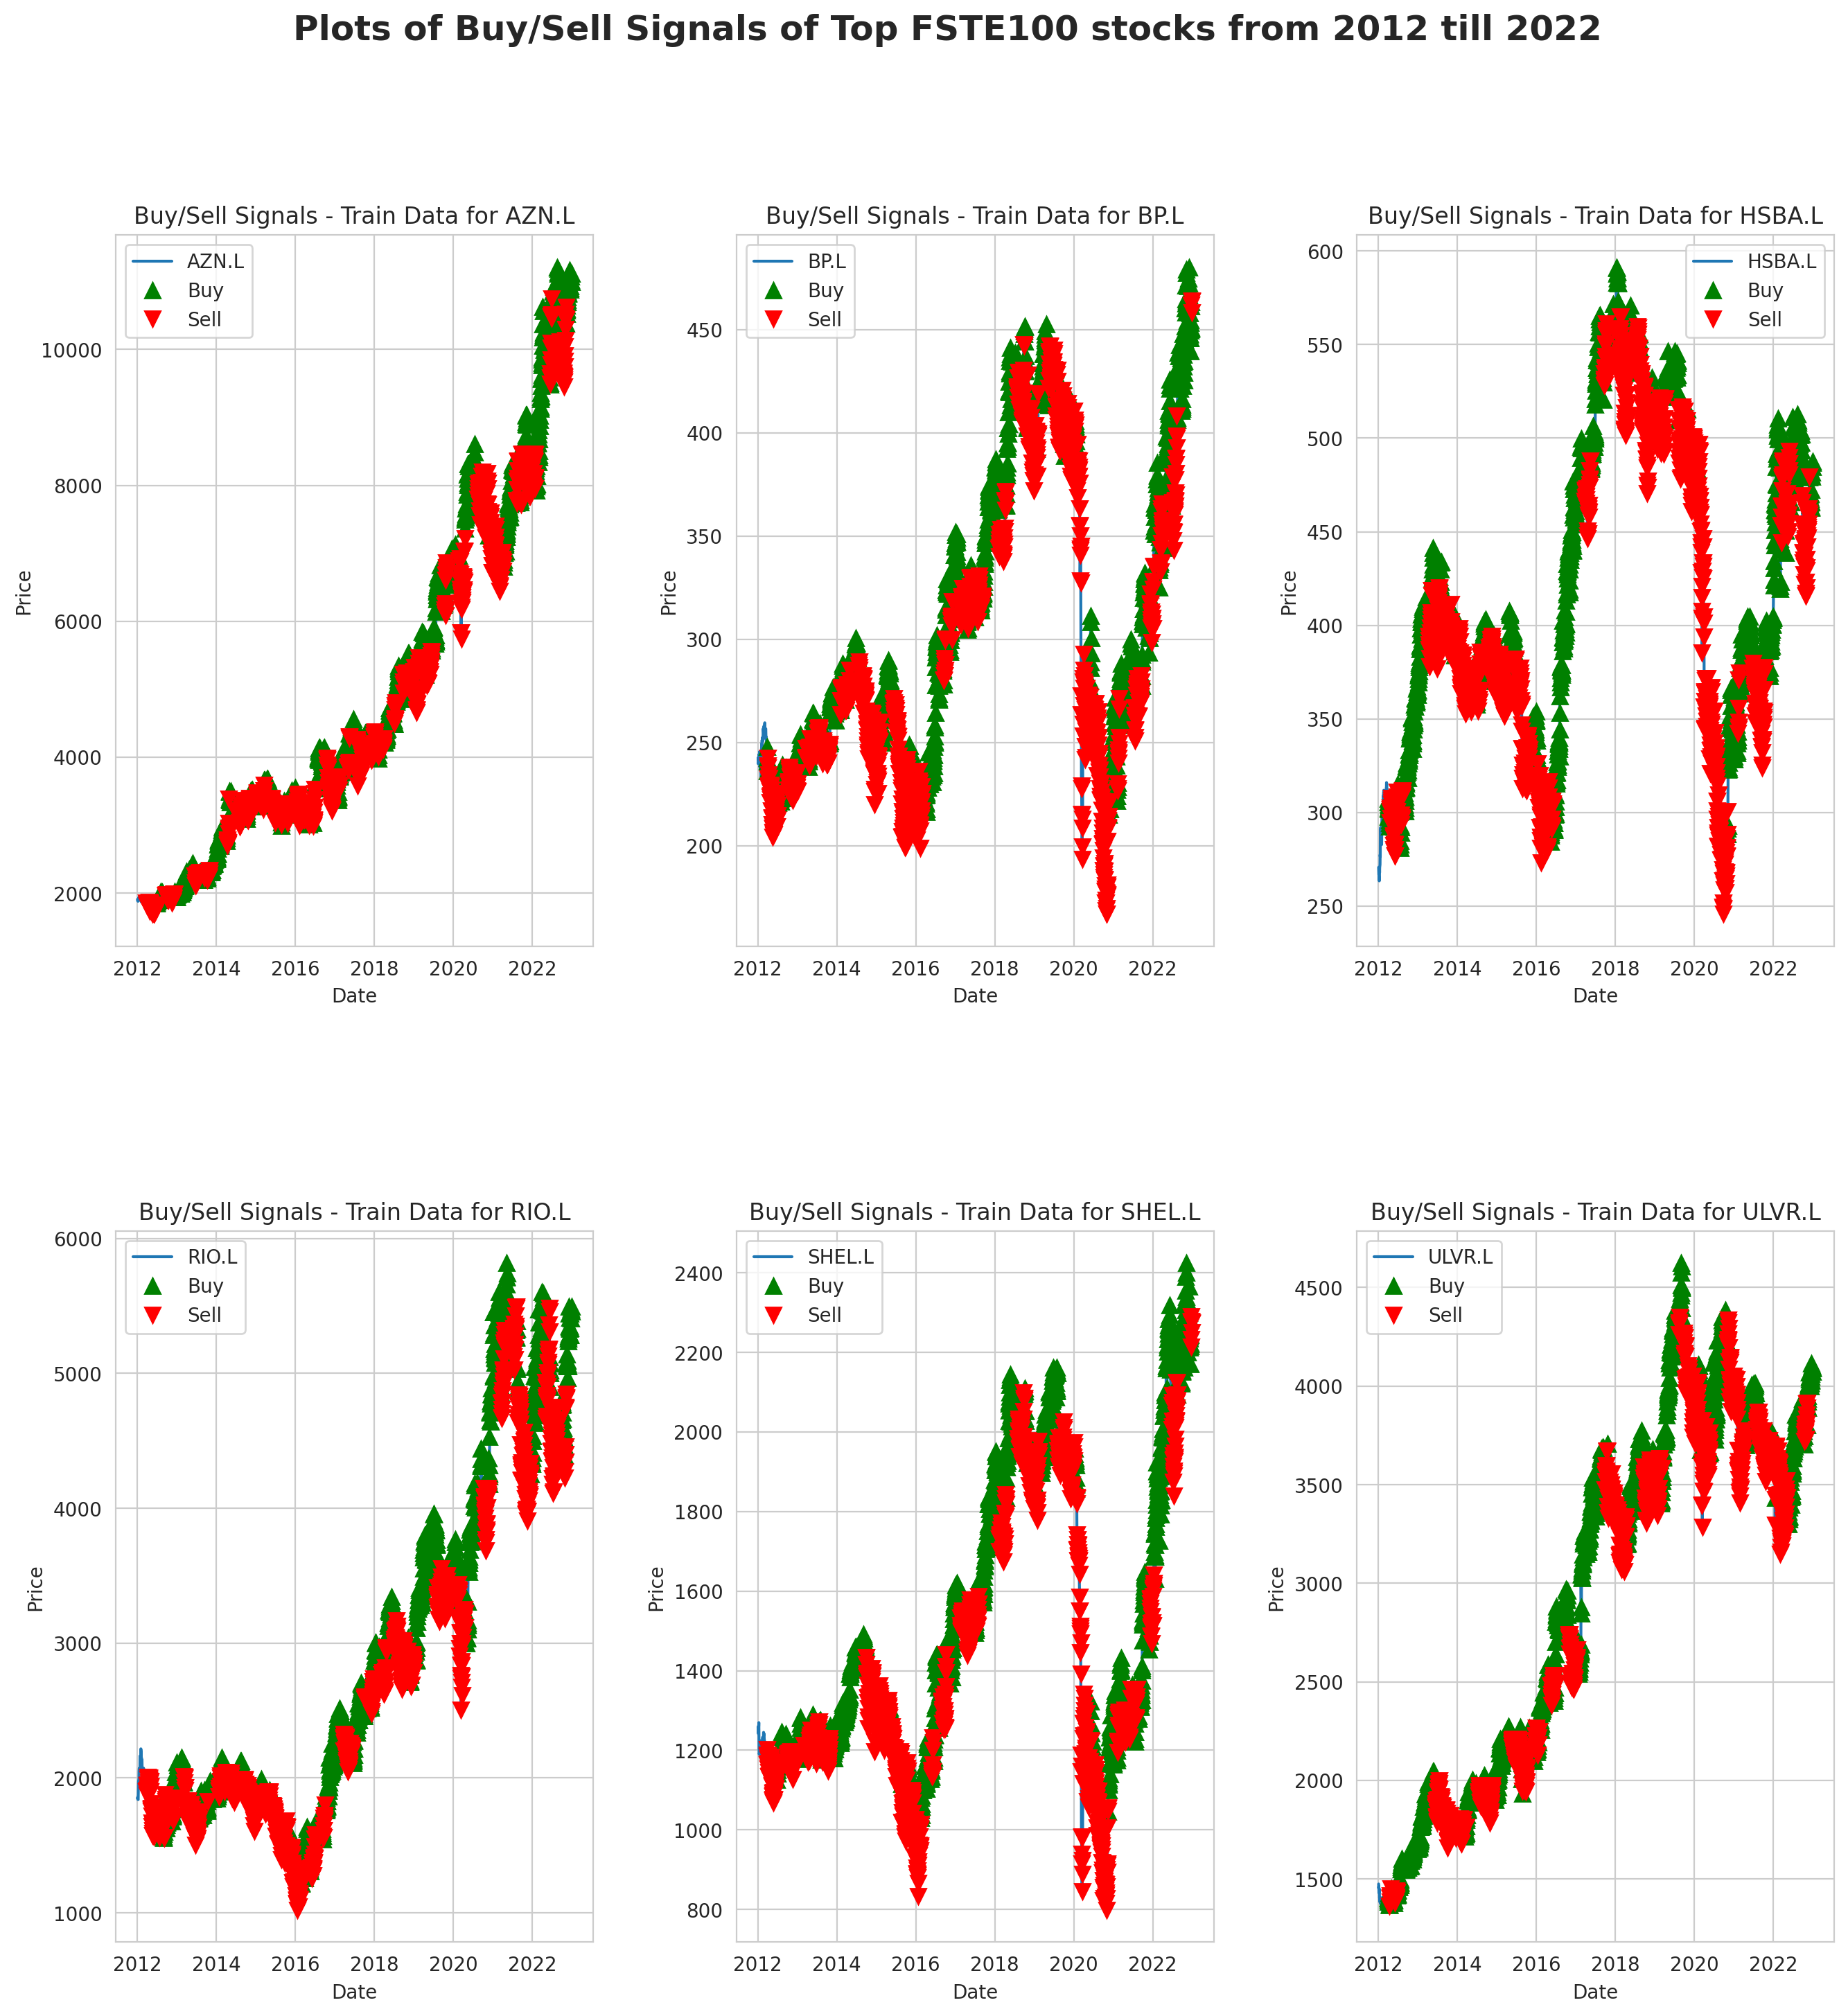

In [ ]:
# create a gridspec with rows 2 and 3 columns for Buy/Sell Signals for the training data
fig = plt.figure(figsize=(16,16), dpi=200)
fig.suptitle('Plots of Buy/Sell Signals of Top FSTE100 stocks from 2012 till 2022', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.3, hspace=0.4)

# Plot buy/sell signals for train data AZN
ax1 = plt.subplot(gs[0,0])
plot_buy_sell_signals(train_data_AZN, stock_AZN, ax=ax1)

# Plot buy/sell signals for train data BP
ax2 = plt.subplot(gs[0,1])
plot_buy_sell_signals(train_data_BP, stock_BP, ax=ax2)

# Plot buy/sell signals for train data HSBA
ax3 = plt.subplot(gs[0,2])
plot_buy_sell_signals(train_data_HSBA, stock_HSBA, ax=ax3)

# Plot buy/sell signals for train data RIO
ax4 = plt.subplot(gs[1,0])
plot_buy_sell_signals(train_data_RIO, stock_RIO, ax=ax4)

# Plot buy/sell signals for train data SHELL
ax5 = plt.subplot(gs[1,1])
plot_buy_sell_signals(train_data_SHELL, stock_SHELL, ax=ax5)

# Plot buy/sell signals for train data ULVR
ax6 = plt.subplot(gs[1,2])
plot_buy_sell_signals(train_data_ULVR, stock_ULVR, ax=ax6)

plt.show()

In [ ]:
# Calculate returns for train and test data for each stocks
# AZN
train_returns_AZN = calculate_returns(train_data_AZN)
test_returns_AZN = calculate_returns(test_data_AZN)

# BP
train_returns_BP = calculate_returns(train_data_BP)
test_returns_BP = calculate_returns(test_data_BP)

# HSBA
train_returns_HSBA = calculate_returns(train_data_HSBA)
test_returns_HSBA = calculate_returns(test_data_HSBA)

#RIO
train_returns_RIO = calculate_returns(train_data_RIO)
test_returns_RIO = calculate_returns(test_data_RIO)

# SHELL
train_returns_SHELL = calculate_returns(train_data_SHELL)
test_returns_SHELL = calculate_returns(test_data_SHELL)

# ULVR
train_returns_ULVR = calculate_returns(train_data_ULVR)
test_returns_ULVR = calculate_returns(test_data_ULVR)

In [ ]:
# Evaluate performance on train and test data for each stock
# AZN
train_performance_AZN = evaluate_performance(train_returns_AZN)
test_performance_AZN = evaluate_performance(test_returns_AZN)

# BP
train_performance_BP = evaluate_performance(train_returns_BP)
test_performance_BP = evaluate_performance(test_returns_BP)

# HSBA
train_performance_HSBA = evaluate_performance(train_returns_HSBA)
test_performance_HSBA = evaluate_performance(test_returns_HSBA)

# RIO
train_performance_RIO = evaluate_performance(train_returns_RIO)
test_performance_RIO = evaluate_performance(test_returns_RIO)

# SHELL
train_performance_SHELL = evaluate_performance(train_returns_SHELL)
test_performance_SHELL = evaluate_performance(test_returns_SHELL)

# ULVR
train_performance_ULVR = evaluate_performance(train_returns_ULVR)
test_performance_ULVR = evaluate_performance(test_returns_ULVR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


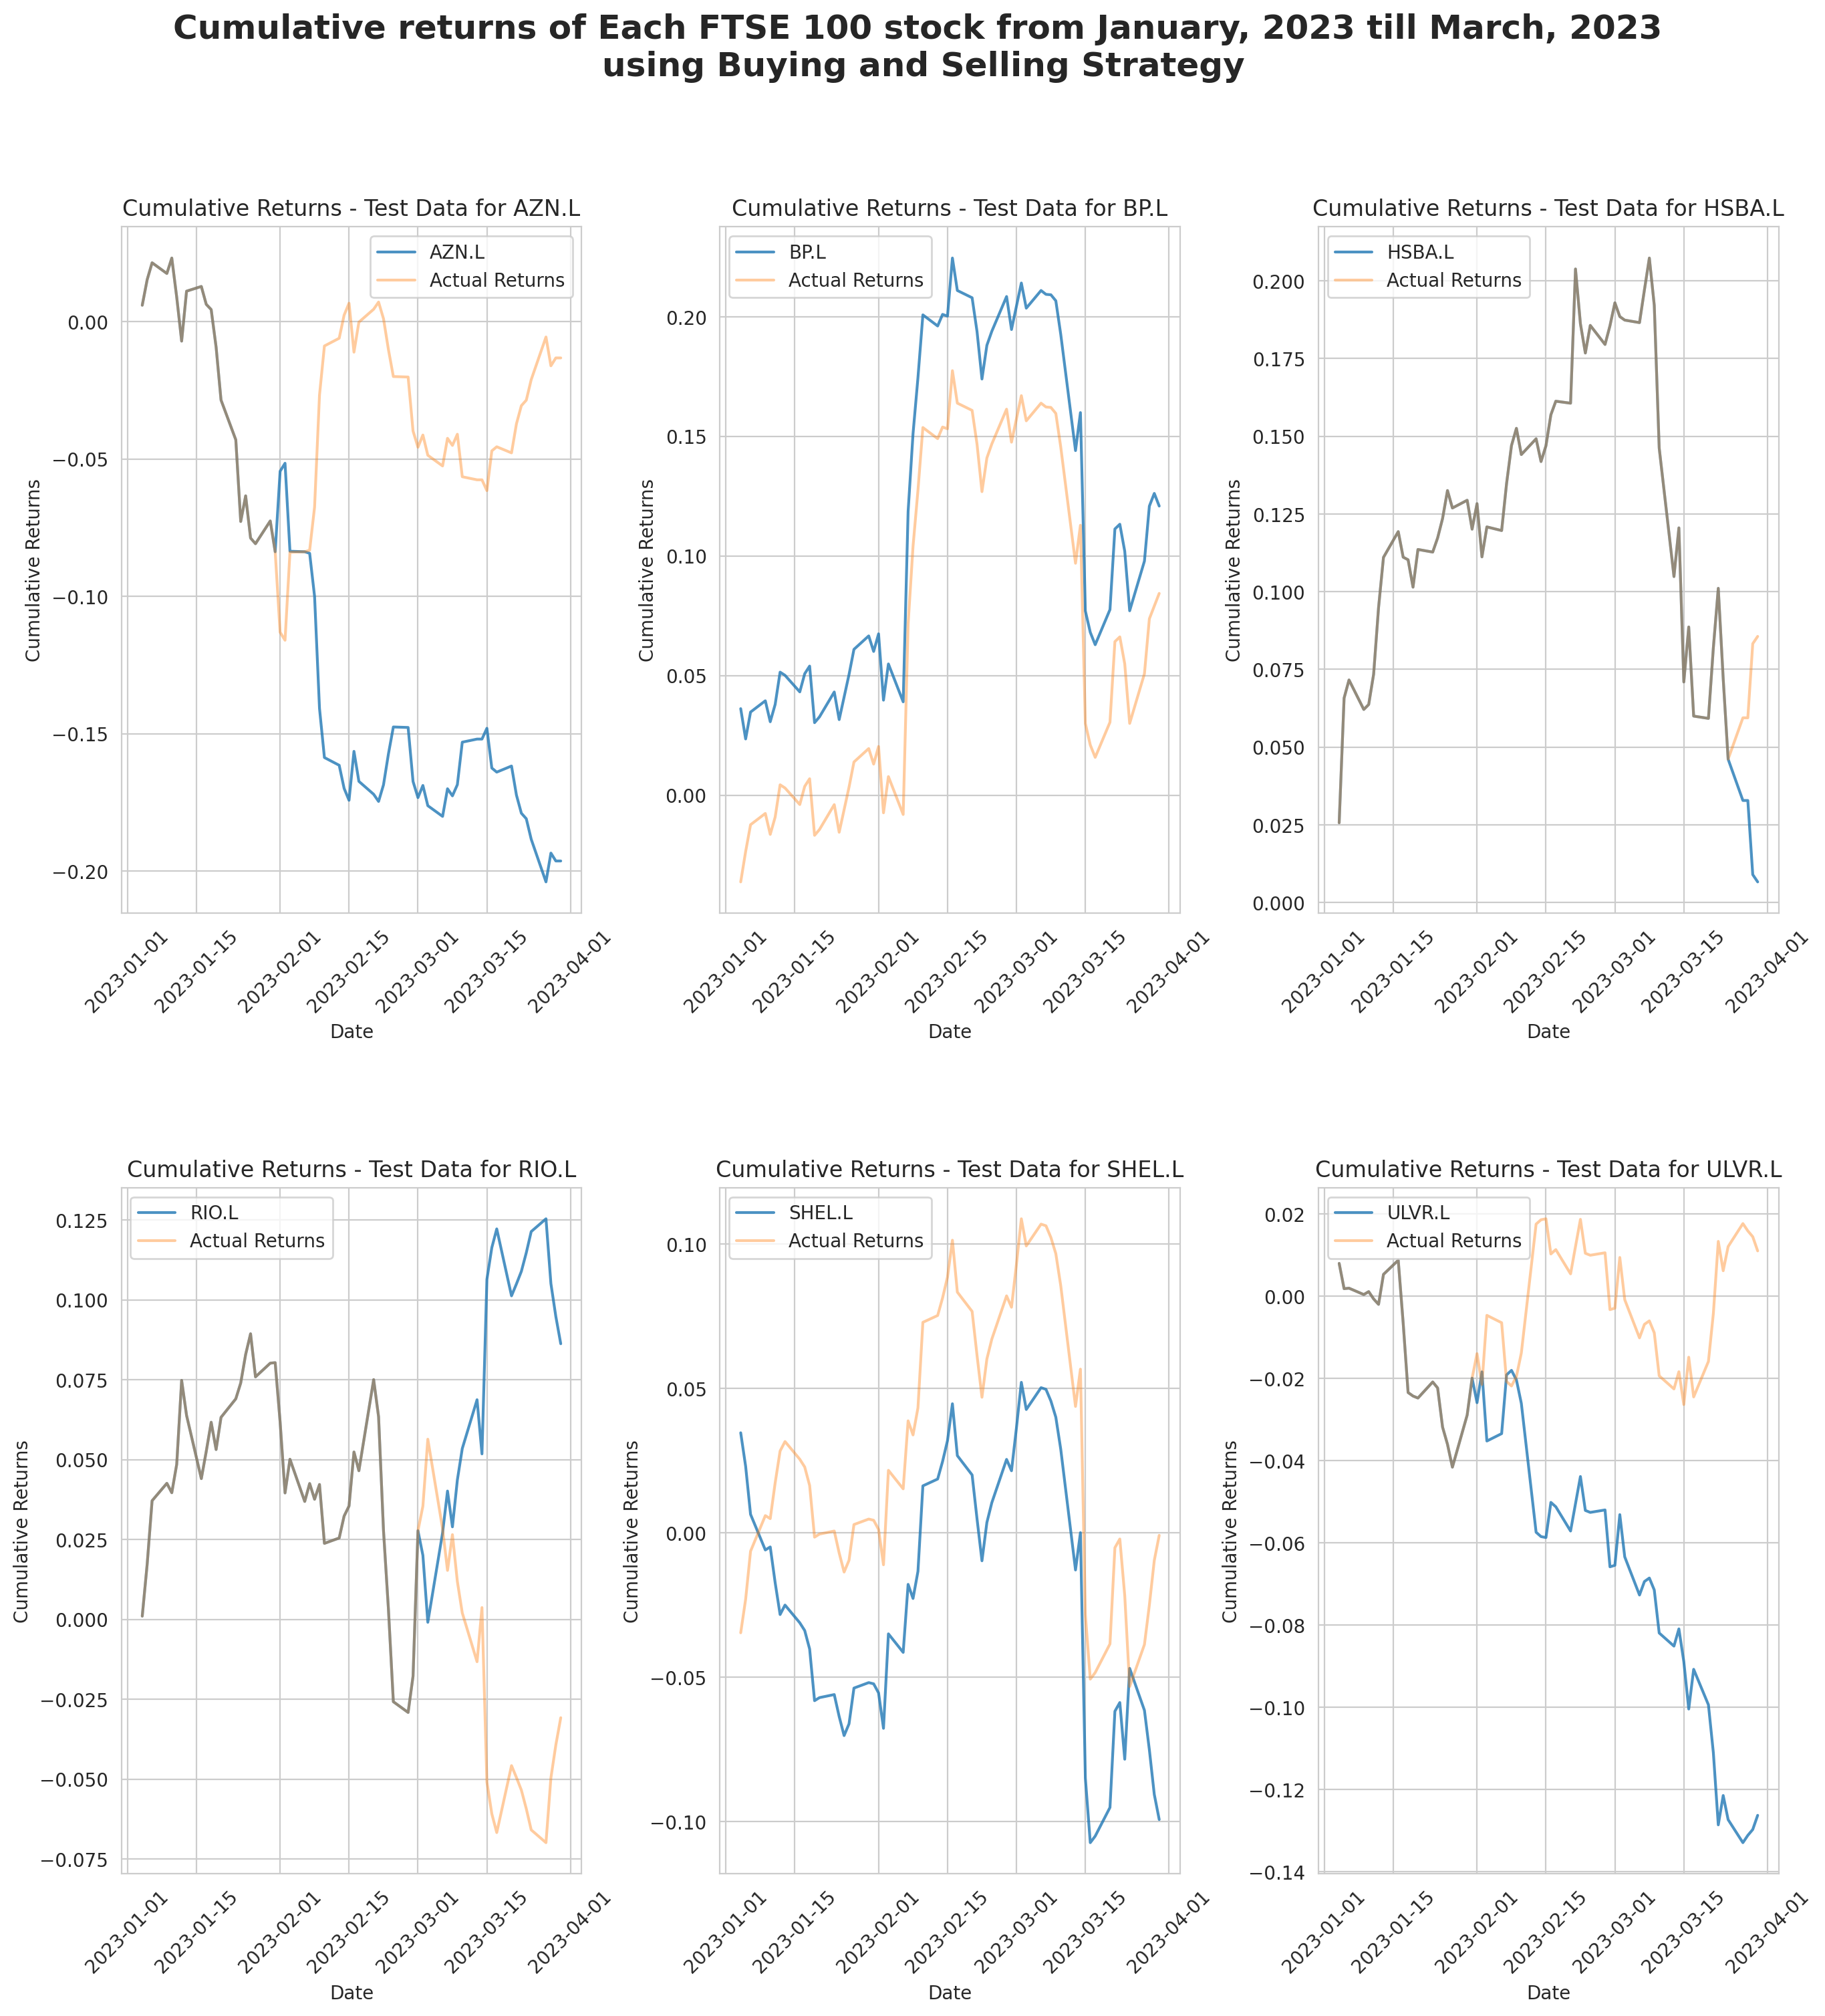

In [ ]:
# create a gridspec with rows 2 and 3 columns for the cumulative sum of returns
fig = plt.figure(figsize=(16,16), dpi=200)
fig.suptitle('Cumulative returns of Each FTSE 100 stock from January, 2023 till March, 2023 \nusing Buying and Selling Strategy', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.3, hspace=0.4)

# Plot cumulative sum of returns for test data AZN
ax1 = plt.subplot(gs[0,0])
plot_cumulative_returns(test_performance_AZN, test_data_AZN, stock_AZN, ax=ax1)

# Plot cumulative sum of returns for test data BP
ax2 = plt.subplot(gs[0,1])
plot_cumulative_returns(test_performance_BP, test_data_BP, stock_BP, ax=ax2)

# Plot cumulative sum of returns for test data HSBA
ax3 = plt.subplot(gs[0,2])
plot_cumulative_returns(test_performance_HSBA, test_data_HSBA, stock_HSBA, ax=ax3)

# Plot cumulative sum of returns for test data RIO
ax4 = plt.subplot(gs[1,0])
plot_cumulative_returns(test_performance_RIO, test_data_RIO, stock_RIO, ax=ax4)

# Plot cumulative sum of returns for test SHELL
ax5 = plt.subplot(gs[1,1])
plot_cumulative_returns(test_performance_SHELL, test_data_SHELL, stock_SHELL, ax=ax5)

# Plot cumulative sum of returns for test data ULVR
ax6 = plt.subplot(gs[1,2])
plot_cumulative_returns(test_performance_ULVR, test_data_ULVR, stock_ULVR, ax=ax6)


plt.show()

# Data Preprocessing for Models

In [ ]:
# Dropping Closing Price Column of df_stock dataframe
stock_data = df_stock.drop('Close', 1)

#Remanimg Adj Close
stock_data = stock_data.rename(columns={'Adj Close':'AdjClose'})

#Sorting the data by Date and stock and resetting the index
stock_data = stock_data.sort_values(by=['Date', 'Stock']).reset_index(drop=True)

In [ ]:
# Function to calculate daily returns for each stock
def calculate_returns(group):
    """This function calculates the daily returns of each stocks using the pct_change formula"""
    group['returns'] = group['AdjClose'].pct_change()
    return group

# Apply the function to each group of stocks (grouped by 'Stock')
stock_data = stock_data.groupby('Stock').apply(calculate_returns)

# Drop NaN from the first row since pct_change() introduces a NaN for the first entry
stock_data.dropna(subset=['returns'], inplace=True)

In [ ]:
# derive the unique dates of each stocks
uniq_date = stock_data.Date.unique()
stocks_df = pd.DataFrame({"Date": uniq_date})

stock_data_FTSE = pd.DataFrame()

# Make changes first calculate the technical indicators and then match all the stocks with dates and then backfill NaN with the last observed valid data
for i in stocks:

  # Forcing all the date ranges to be same for all stocks
  temp = pd.merge(stocks_df, stock_data[stock_data['Stock'] == i], how='left', on= 'Date')

  # Filling the missing values by using the back fill method
  temp = temp.fillna(method='bfill')

  print('Shape of {} before merging : {} | after merging : {}'.format(i, stock_data[stock_data['Stock'] == i].shape, temp.shape))

  #Adding all the available technical indicators
  stock_FTSE = ta.add_all_ta_features(df= temp, open= 'Open', high= 'High', low= 'Low', close='AdjClose', volume = 'Volume', fillna=True)

  stock_data_FTSE = stock_data_FTSE.append(stock_FTSE)

Shape of AZN.L before merging : (2840, 8) | after merging : (2840, 8)
Shape of BP.L before merging : (2833, 8) | after merging : (2840, 8)
Shape of HSBA.L before merging : (2840, 8) | after merging : (2840, 8)
Shape of RIO.L before merging : (2839, 8) | after merging : (2840, 8)
Shape of SHEL.L before merging : (2839, 8) | after merging : (2840, 8)
Shape of ULVR.L before merging : (2840, 8) | after merging : (2840, 8)


In [ ]:
# show a 5 sample rows from the stock_data_FTSE dataframe
stock_data_FTSE[['Date', 'Stock', 'Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci' ]].sample(5)

,Date,Stock,Open,High,Low,AdjClose,Volume,momentum_ppo,momentum_rsi,trend_adx,trend_macd,trend_cci
1520,2018-01-10,RIO.L,4062.500000,4094.000000,4050.000000,2944.896973,5376551.0,3.323139,77.427952,47.015862,91.292153,114.462039
1293,2017-02-15,ULVR.L,3293.000000,3321.000000,3273.000000,2659.034912,3425675.0,0.361876,56.368364,16.400815,9.503784,27.612347
2596,2022-04-11,BP.L,390.049988,393.850006,385.450012,360.919586,38512438.0,0.782816,54.621874,9.080730,2.764583,104.308228
1799,2019-02-15,SHEL.L,2420.000000,2448.000000,2414.500000,1977.181519,6864048.0,1.475345,62.728637,23.802181,28.279991,67.150174
876,2015-06-25,HSBA.L,600.000000,602.400024,594.099976,377.065796,33773392.0,-0.887481,38.816718,11.231235,-3.414026,-69.620030


# Preprocessing for GRU and LSTM Model

In [ ]:
train_df = stock_data_FTSE[(stock_data_FTSE.Date >= '2012-01-01') & (stock_data_FTSE.Date < '2023-01-01')].sort_values(['Stock'])
test_df = stock_data_FTSE[(stock_data_FTSE.Date >= '2023-01-01')].sort_values(['Stock'])

In [ ]:
features = ['Open', 'High', 'Low', 'AdjClose', 'Volume','momentum_ppo', 'momentum_rsi','trend_adx', 'trend_macd', 'trend_cci']
label = 'returns'
lookback = 5

# create a function that proprecesses Stock_data_FTSE for models application
def preprocess_data(df, result):
    """This function scales the features of the stock_data_FTSE and also creates a lookback sequencing for the model"""
    X = df[features].values
    y = df[label].values

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    X_sequences = []
    y_sequences = []

    for i in range(len(X_scaled) - lookback + 1):
        X_sequences.append(X_scaled[i:i+lookback])
        y_sequences.append(y[i+lookback-1])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    if result == 'train':
        X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.25, shuffle=True)
        return X_train, X_val, y_train, y_val
    else:
        return X_sequences, y_sequences

X_train, X_val, y_train, y_val = preprocess_data(train_df, 'train')
X_test, y_test = preprocess_data(test_df, 'test')

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_val: ", y_val.shape)


Shape of X_train:  (12493, 5, 10)
Shape of y_train:  (12493,)
Shape of X_test:  (374, 5, 10)
Shape of y_test:  (374,)
Shape of X_val:  (4165, 5, 10)
Shape of y_val:  (4165,)


#GRU MODEL

In [ ]:
# GRU Model using Sequential API
GRU_model = Sequential(name='GRU')
GRU_model.add(GRU(64, input_shape=(lookback, len(features))))
GRU_model.add(Dense(1))
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = GRU_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=0)

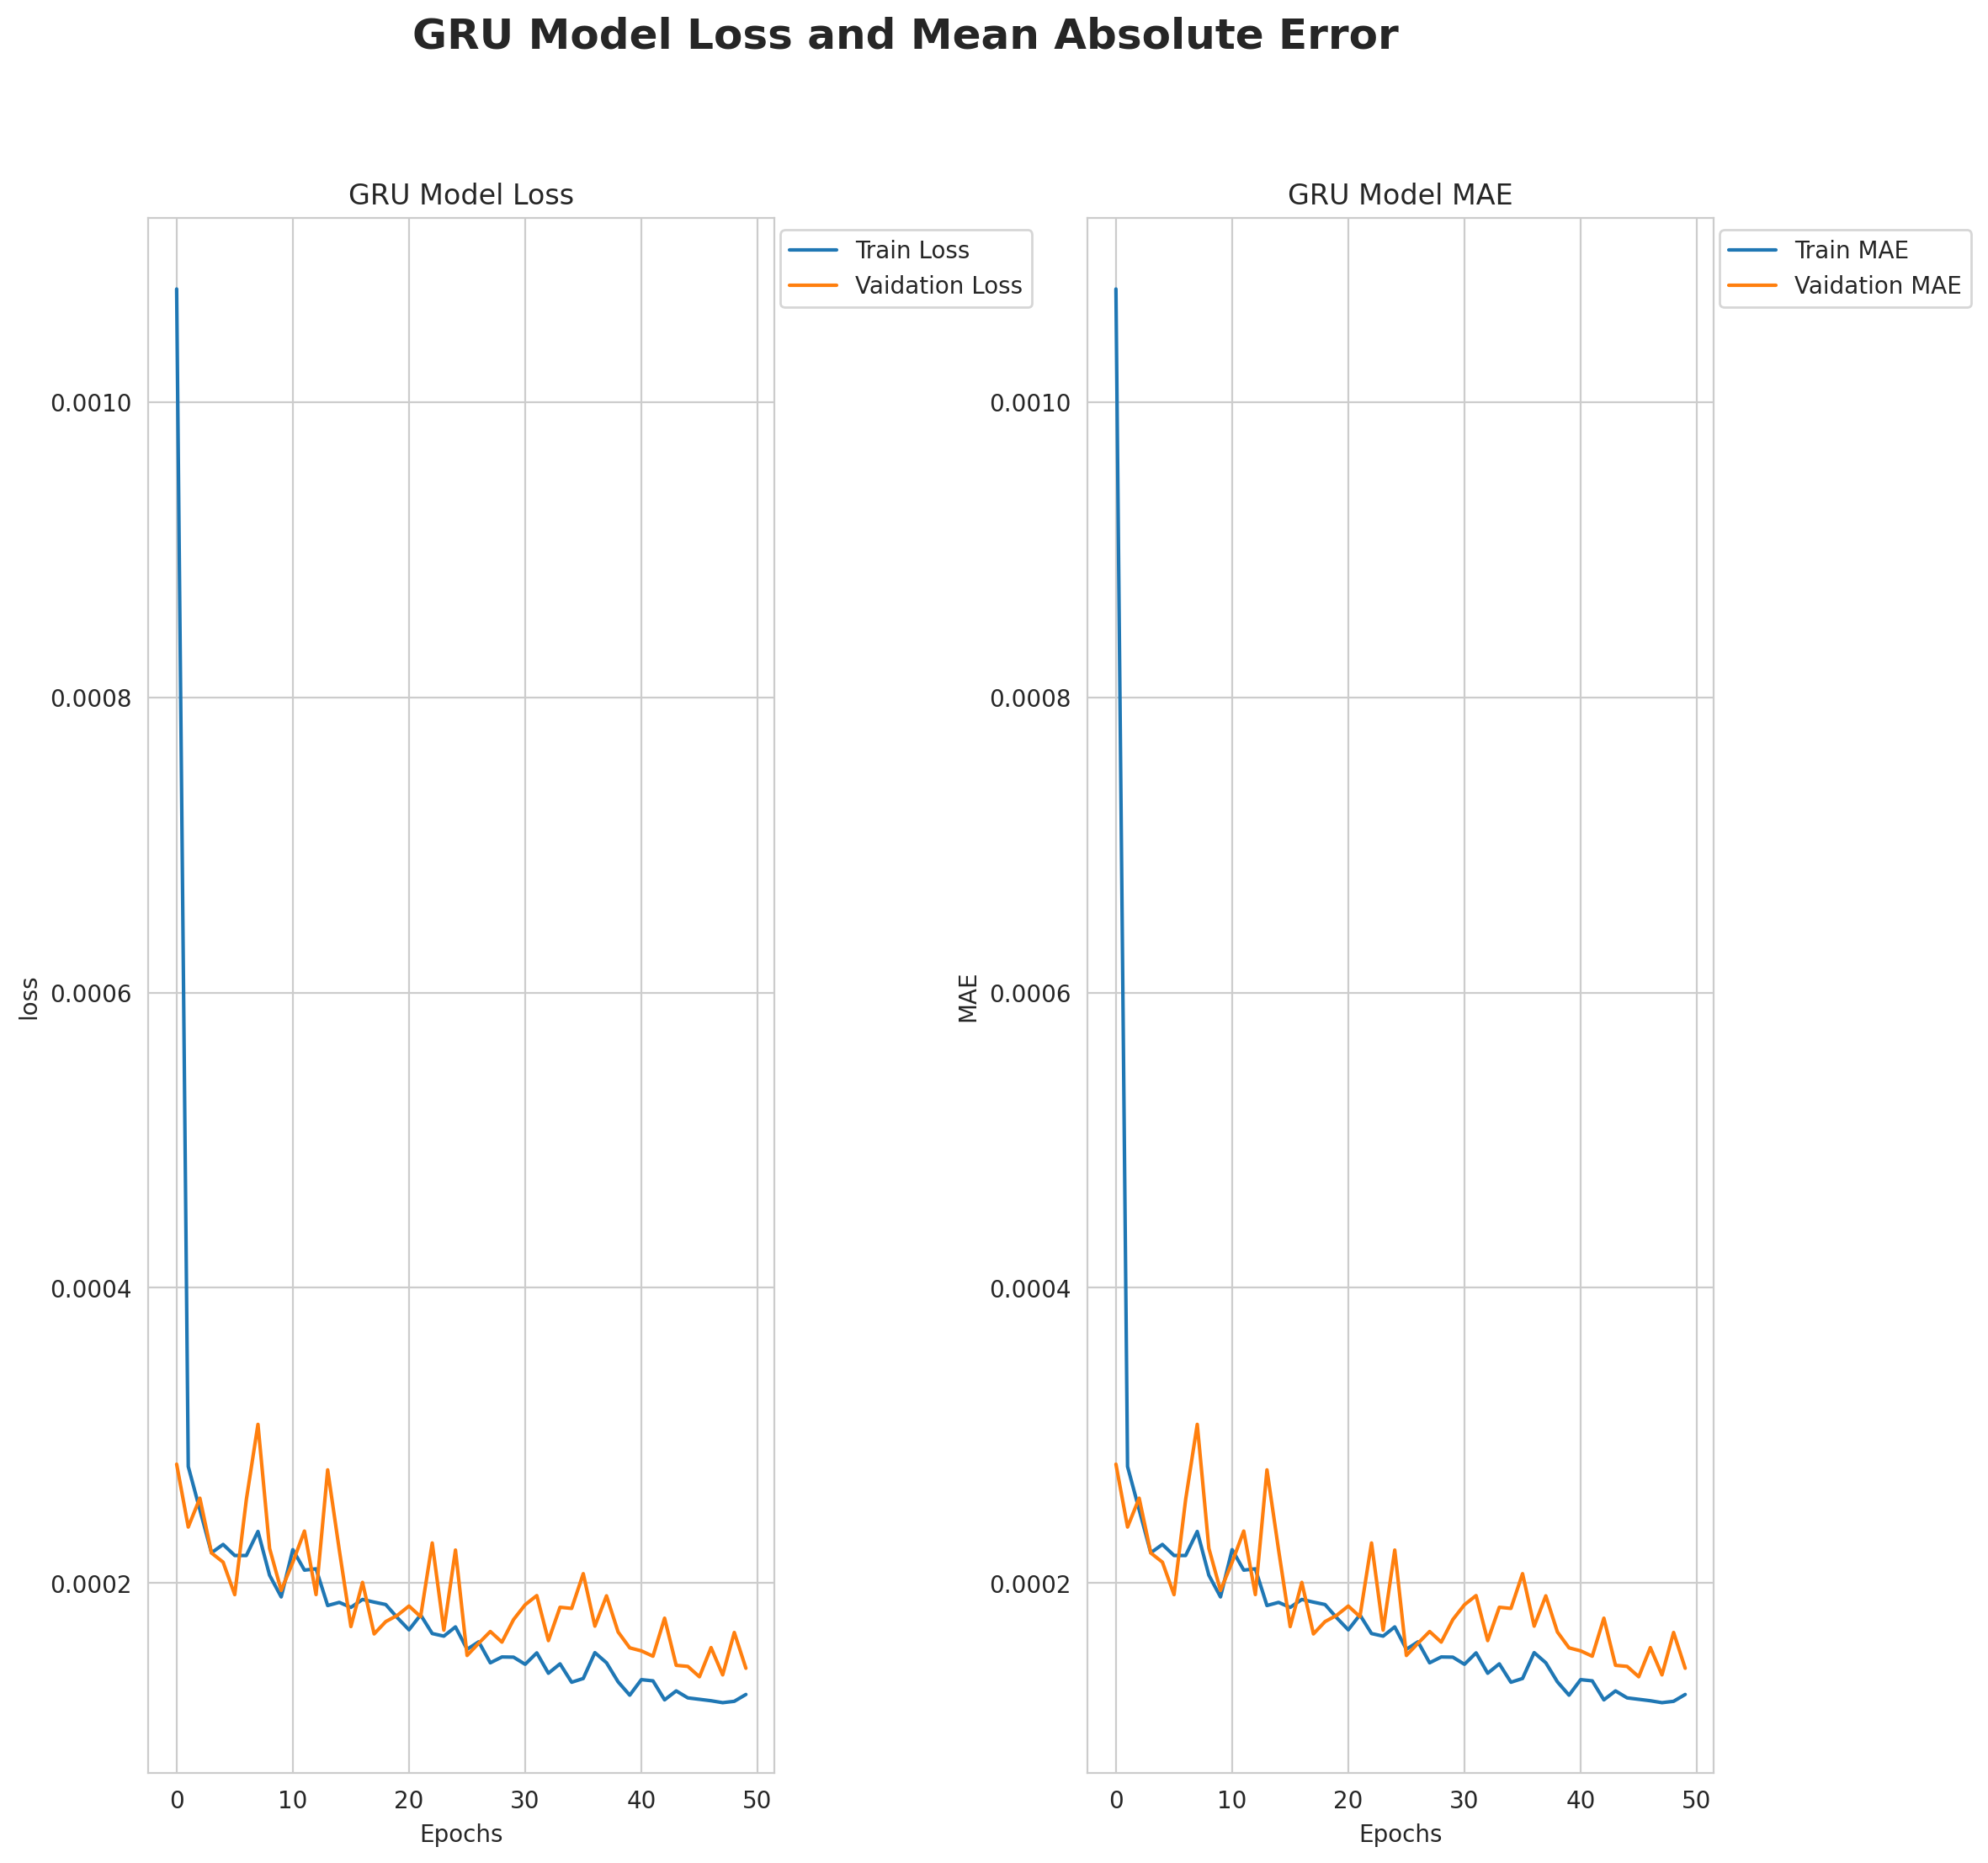

In [ ]:
# create a gridspec with rows 1 and 2 columns for the GRU model loss and Mean Absolute Error
fig = plt.figure(figsize=(12,12), dpi=200)
fig.suptitle('GRU Model Loss and Mean Absolute Error', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.5, hspace=0.4)
ax1 = plt.subplot(gs[0,0])
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Vaidation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('loss')
ax1.set_title('GRU Model Loss')
ax1.legend(bbox_to_anchor=(1.43, 1.0))

ax2 = plt.subplot(gs[0,1])
ax2.plot(history.history['mse'], label='Train MAE')
ax2.plot(history.history['val_mse'], label='Vaidation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('GRU Model MAE')
ax2.legend(bbox_to_anchor=(1.43, 1.0))

plt.tight_layout()
plt.show()

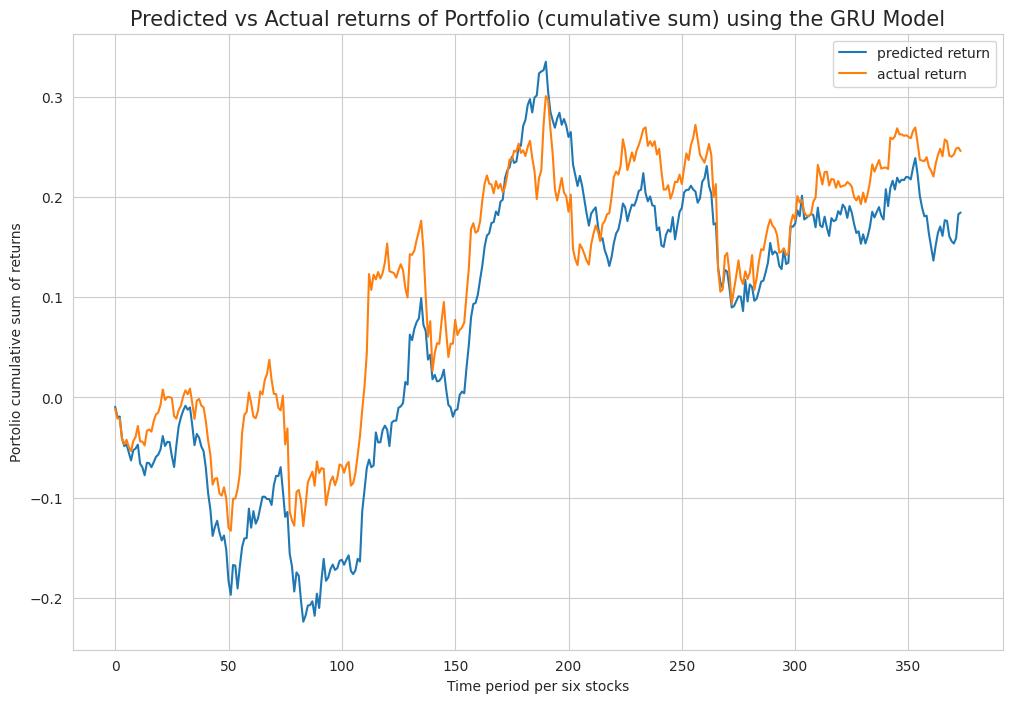

In [ ]:
# predictions based on GRU Model
y_pred = GRU_model.predict(X_test, verbose=0)
pred_return = y_pred.cumsum()
actual_return = y_test.cumsum()
print('\n')
print('\n')
plt.figure(figsize=(12,8), dpi=100)
plt.plot(pred_return, label='predicted return')
plt.plot(actual_return, label='actual return')
plt.xlabel('Time period per six stocks')
plt.ylabel('Portolio cumulative sum of returns')
plt.title('Predicted vs Actual returns of Portfolio (cumulative sum) using the GRU Model', fontsize=15)
plt.legend()
plt.show()

In [ ]:
# evaluate GRU model
GRU_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error using GRU: {GRU_mse}")

Mean Squared Error using GRU: 0.00015587122591533177


#LSTM MODEL

In [24]:
# LSTM Model Using Sequential API
LSTM_model = Sequential(name='LSTM')
LSTM_model.add(LSTM(64, input_shape=(lookback, len(features))))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history2 = LSTM_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=0)

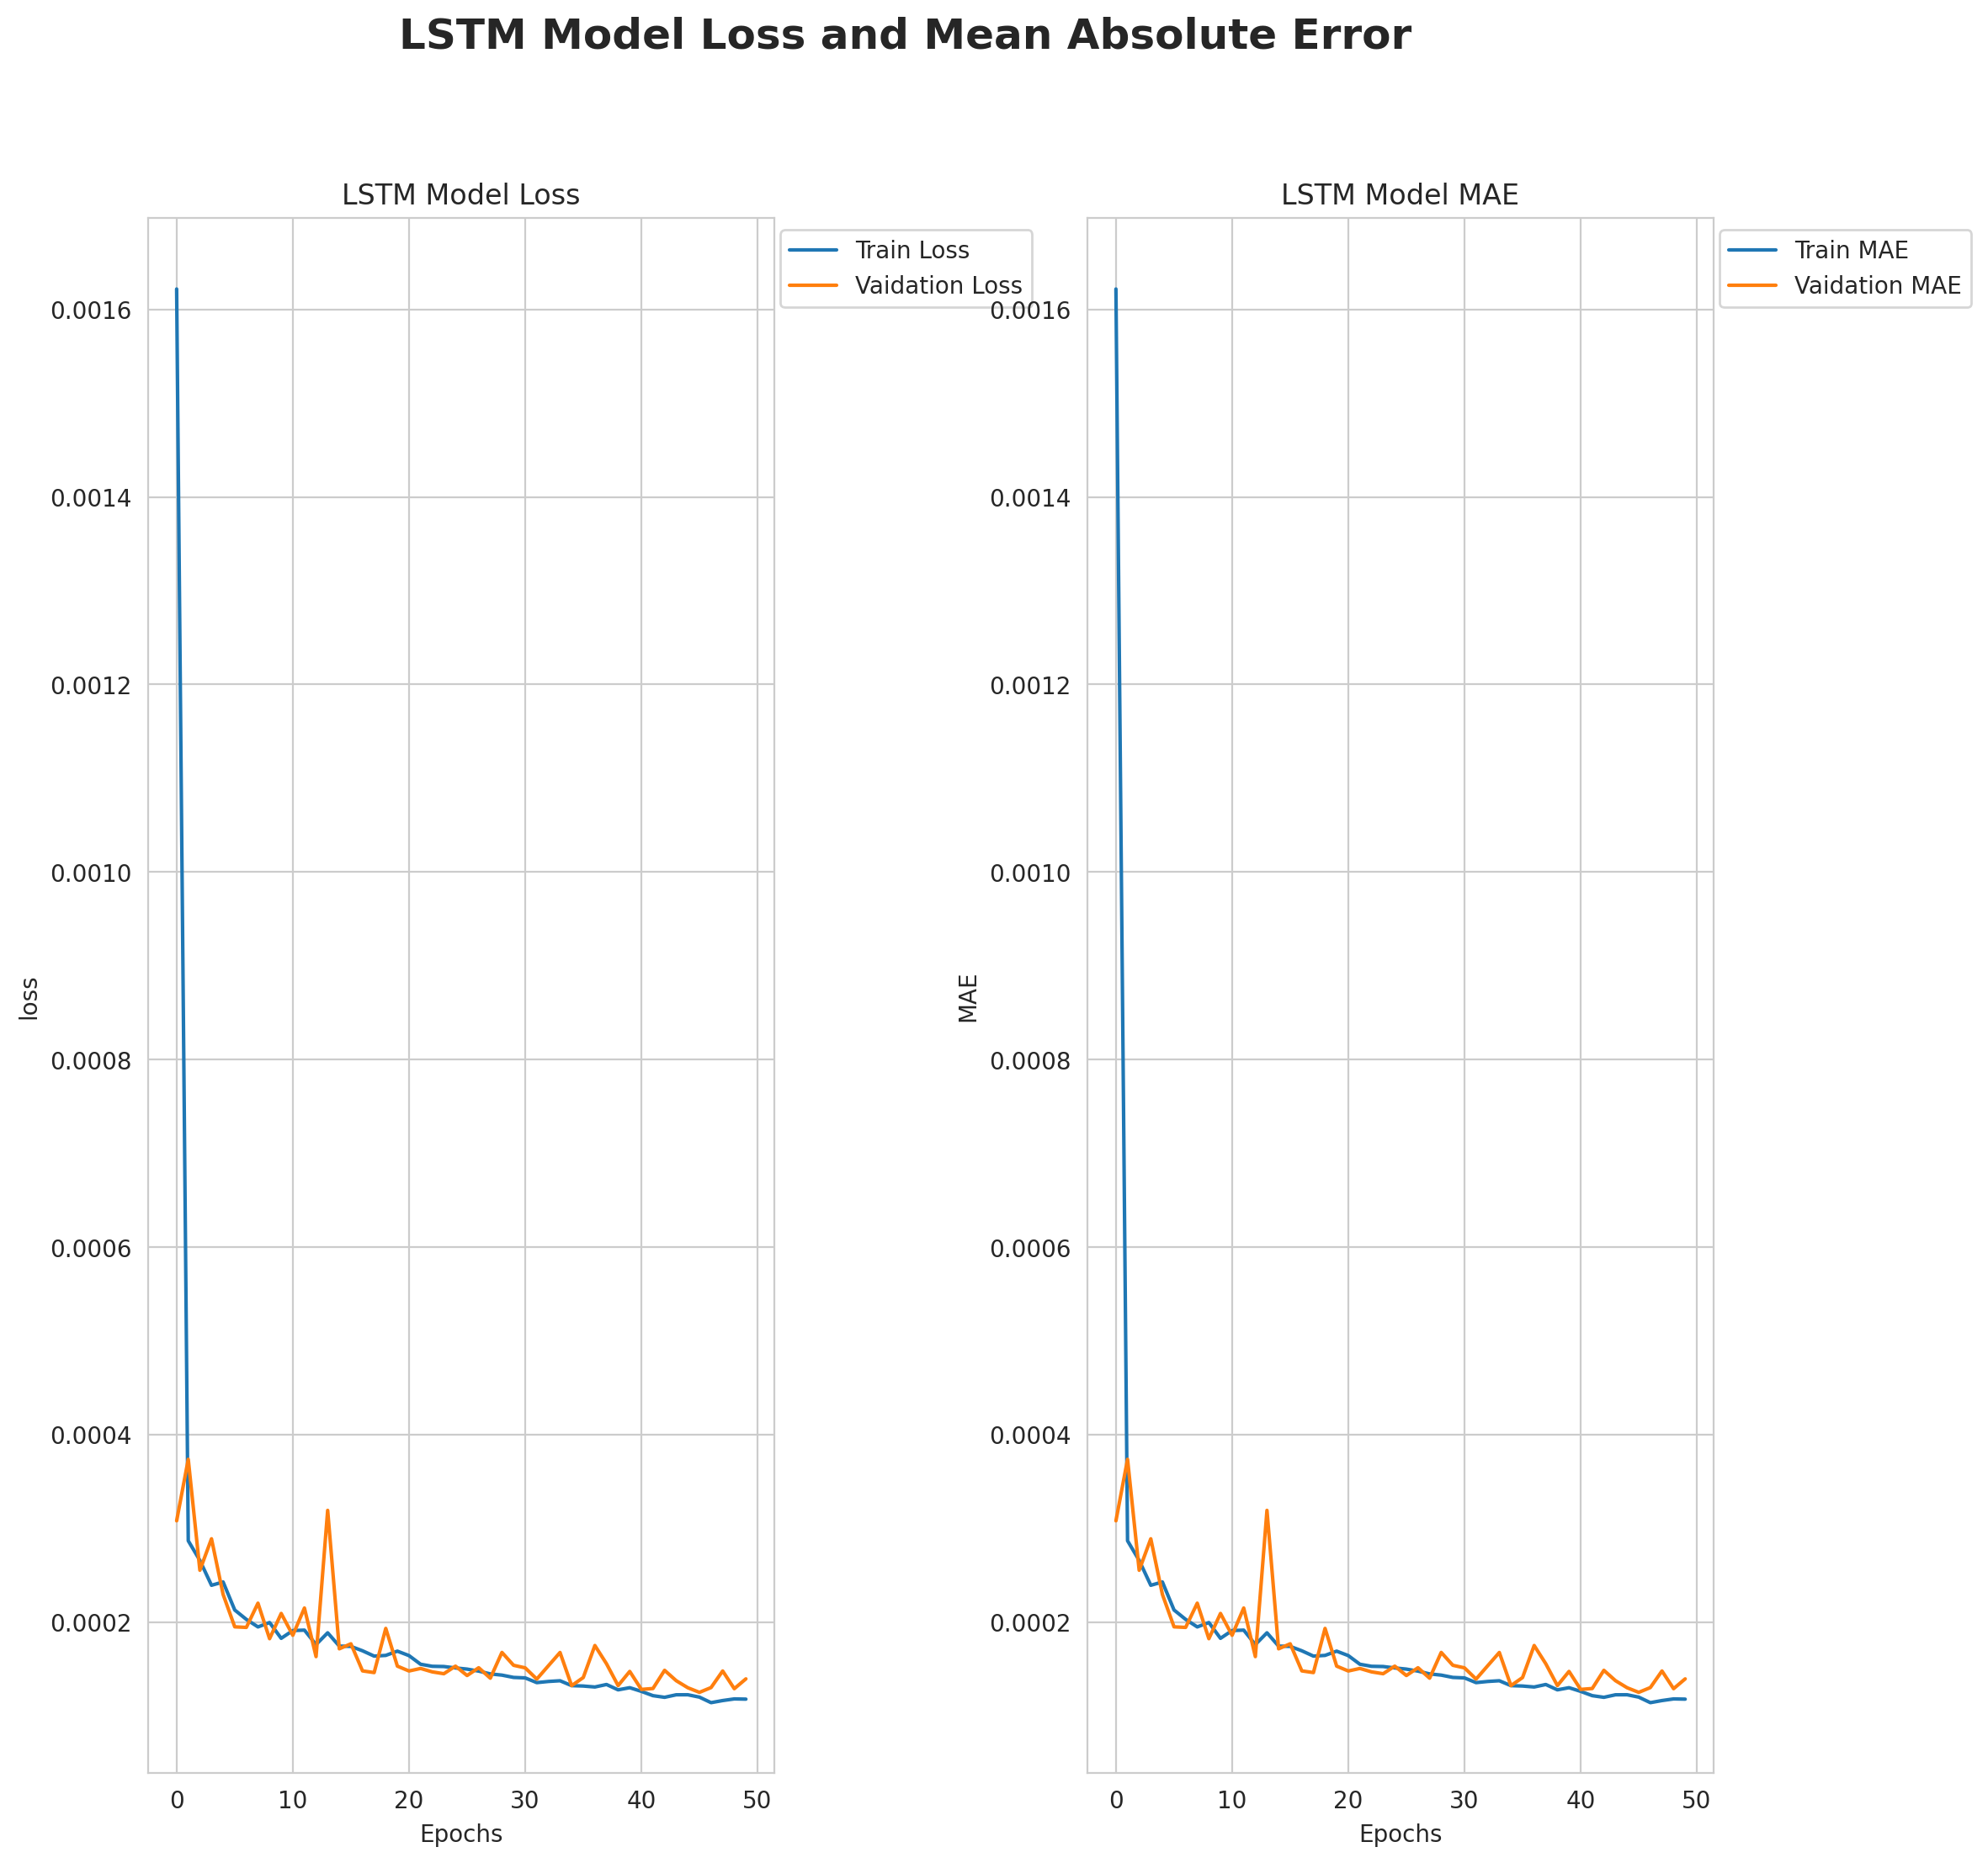

In [27]:
# create a gridspec with rows 1 and 2 columns for the LSTM model loss and Mean Absolute Error
fig = plt.figure(figsize=(12,12), dpi=200)
fig.suptitle('LSTM Model Loss and Mean Absolute Error', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.5, hspace=0.4)
ax1 = plt.subplot(gs[0,0])
ax1.plot(history2.history['loss'], label='Train Loss')
ax1.plot(history2.history['val_loss'], label='Vaidation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('loss')
ax1.set_title('LSTM Model Loss')
ax1.legend(bbox_to_anchor=(1.43, 1.0))

ax2 = plt.subplot(gs[0,1])
ax2.plot(history2.history['mse'], label='Train MAE')
ax2.plot(history2.history['val_mse'], label='Vaidation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('LSTM Model MAE')
ax2.legend(bbox_to_anchor=(1.43, 1.0))

plt.tight_layout()
plt.show()

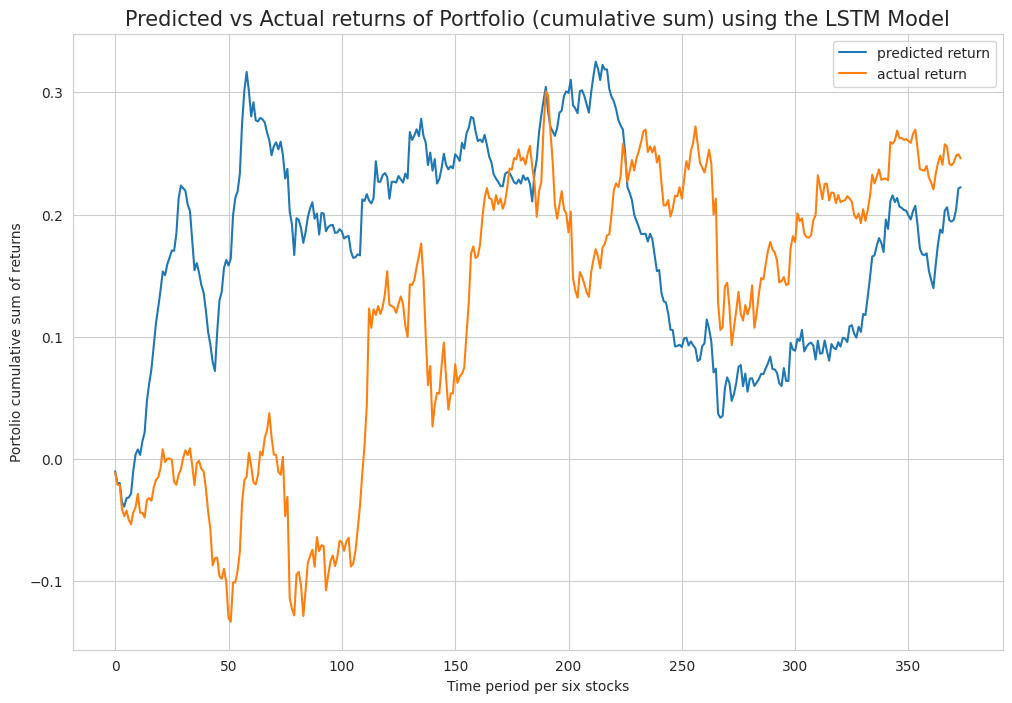

In [25]:
# predictions based on LSTM model
y_pred = LSTM_model.predict(X_test, verbose=0)
actual_return = y_test.cumsum()
pred_return = y_pred.cumsum()
print('\n')
print('\n')
plt.figure(figsize=(12,8), dpi=100)
plt.plot(pred_return, label='predicted return')
plt.plot(actual_return, label='actual return')
plt.xlabel('Time period per six stocks')
plt.ylabel('Portolio cumulative sum of returns')
plt.title('Predicted vs Actual returns of Portfolio (cumulative sum) using the LSTM Model', fontsize=15)
plt.legend()
plt.show()

In [26]:
# evaluate LSTM model
LSTM_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error using LSTM: {LSTM_mse}")

Mean Squared Error using LSTM: 0.00018535220213107084


# Deep Reinforcement Learning

In [ ]:
class FTSEStockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, Shares_Per_Trade, Initial_Investment, Action_Space, Observation_Space, day=0,
                 Normalized_Rewards=1e-4, verbosity=0, mode='train', seed=10, commission=0):

      self.day = day
      self.df = df
      self.max_shares_per_trade = Shares_Per_Trade
      self.initial_investment = Initial_Investment
      self.Action_Space = Action_Space
      self.Observation_Space = Observation_Space
      self.normalized_rewards = Normalized_Rewards
      self.verbosity = verbosity
      self.commission = commission
      #self.model = model
      self.mode = mode
      self._seed(seed)


      #Action Space
      # Action > 0  means buy shares of stock
      # Action 0 means Hold the stock
      # Action < 0 means sell shares of stock
      self.action_space = spaces.Box(low=-1, high=1,
                                     shape=(self.Action_Space,), dtype=np.int64)

      #Observation Space
      self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.Observation_Space,))

      #Selecting the Data for one date
      self.data = self.df.loc[self.day,:]

      #Initial Run
      self.initial = True

      #Verify if tradings days are completed or not
      self.done = False

      #Rewards
      self.reward = 0

      #Asset value after each trading day
      self.asset_memory = [self.initial_investment]

      #Rewards received for each trading day i.e profit or loss
      self.reward_memory = []

      #Saving the date for the trade
      self.date_memory = [self.data.Date.unique()[0]]

      #Initializing state of the environment

      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()


    def render(self, mode='human'):
      return self.state

    # This method is used to reset the values of the state to it's default after every episode
    def reset(self):

      self.day = 0
      self.reward = 0
      self.data = self.df.loc[self.day,:]
      self.done = False
      self.initial = False
      self.reward_memory = []
      self.date_memory = [self.data.Date.unique()[0]]
      self.asset_memory = [self.initial_investment]
      self.state = [self.initial_investment] + self.data.AdjClose.values.tolist() + [0]*self.Action_Space + \
        self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
        self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
        self.data.trend_cci.values.tolist()
      #print(self.state)
      return self.state

    def step(self, actions):
      self.done = self.day >= len(self.df.Date.unique())-1

      #Use this to save the results to csv after we performed trading for all the days
      if self.done:

        final_portfolio_value = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        total_rewards = final_portfolio_value - self.initial_investment
        profit_pct = (total_rewards*100)/self.initial_investment

        asset_df = pd.DataFrame(self.asset_memory)
        asset_df.columns = ['portfolio']
        asset_df['date'] = self.date_memory

        if self.verbosity and self.mode != 'train':
          print(f'Initial Portfolio Value : {self.initial_investment} | Final Portfolio Value : {final_portfolio_value} | Total rewards : {total_rewards} | % of profit : {profit_pct}')
          asset_df.to_csv('{}_{}_results'.format(self.mode, self.commission))
        return self.state, self.reward, self.done, {}

      else:

        #Calculating the portfolio value before start of trading
        #Available investment amount + sum of value of each stock held (no.of shares per stock * price of the stock on that day)
        portfolio_before_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))

        #Extracting the indicies of sell action
        #if actions is not an array then convert it to array using np.array()
        sell_indices = np.where(actions <  0 )[0]

        #Extracting the indicies of buy action
        buy_indices = np.where(actions >  0 )[0]

        ### Trading starts ###
        # Initially selling the stocks to increase investment value
        for idx in sell_indices:
          #Sell stock if price is > 0 and shares held > 0

          if self.state[idx+1] > 0 and self.state[idx+self.Action_Space+1] > 0:

            #No of shares to sell
            shares_sell = min(self.state[idx+self.Action_Space+1], abs(actions[idx]*self.max_shares_per_trade))

            #Updating the available cash after selling the stocks
            self.state[0] += self.state[idx+1]*shares_sell*(1-self.commission)

            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] -= shares_sell

          else:
            # print('No Shares to sell')
            pass

        #print('Buying Stock shares : ')
        for idx in buy_indices:
          #Buy stocks if price is > 0

          if self.state[idx+1] > 0 and self.state[0] > 0:

            #Max number of shares that can be brought with the available cash (available cash / stock price)
            max_shares_buy = self.state[0]*(1 - self.commission)//self.state[idx+1]

            #No of shares to buy
            shares_buy = min(max_shares_buy, actions[idx]*self.max_shares_per_trade)

            #Updating the available cash after selling the stocks
            self.state[0] -= self.state[idx+1]*shares_buy*(1 + self.commission)

            #Updating the available stocks after selling
            self.state[idx+self.Action_Space+1] += shares_buy

          else:
            # print('No Shares purchased')
            pass


        #Setting the values for next trading date
        self.day += 1
        self.data = self.df.loc[self.day,:]

        self.state = [self.state[0]] + self.data.AdjClose.values.tolist() + list(self.state[(self.Action_Space+1):(2*self.Action_Space)+1]) + \
                      self.data.momentum_ppo.values.tolist() + self.data.momentum_rsi.values.tolist() + \
                      self.data.trend_adx.values.tolist() + self.data.trend_macd.values.tolist() + \
                      self.data.trend_cci.values.tolist()


        portfolio_after_trade = self.state[0] + sum(np.array(self.state[1:self.Action_Space+1])*
                                                     np.array(self.state[self.Action_Space+1:(2*self.Action_Space)+1]))
        #Total trade in a day (profit or loss)
        self.reward = portfolio_after_trade - portfolio_before_trade
        #print('Day : {} | Reward : {}'.format(self.day-1, self.reward))
        self.reward_memory.append(self.reward)
        self.asset_memory.append(portfolio_after_trade)
        self.date_memory.append(self.data.Date.unique()[0])

        self.reward = self.reward*self.normalized_rewards     #Normalizing the reward

        return self.state, self.reward, self.done, {}


    def _seed(self, seed=10):
      randomState, seed = seeding.np_random(seed)
      return [seed]

In [ ]:
# a function that simulates trading episodes and works on a pre-trained model
def render_trading(model, env, data, n_episodes=1):
  episode_rewards = [0.0]
  obs = env.reset()
  env.render()

  for i in range(n_episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        #print(action)
        obs, rewards, done, info = env.step(action)
        env.render()

        # Stats
        if done:
          obs = train_env.reset()
          #print('Episode {} Rewards {}'.format(i+1, episode_rewards[-1]))
          episode_rewards.append(0.0)
        else:
          #print(rewards)
          episode_rewards[-1] += rewards

    if (i+1)%10 == 0 and i != 0:
      print('Average reward {}'.format(np.average(episode_rewards[:i+1])))

  return episode_rewards

In [ ]:
stock_df = stock_data_FTSE.copy()

#Training Data - 2012 --> 2011
train_data = stock_df[(stock_df.Date >= '2012-01-01') & (stock_df.Date < '2022-01-01')].sort_values(by=['Date', 'Stock'])

#Validation Data - 2022
validation_data = stock_df[(stock_df.Date >= '2022-01-01') & (stock_df.Date < '2023-01-01')]
validation_data.sort_values(['Date', 'Stock'], ignore_index=True)
validation_data.index = validation_data.Date.factorize()[0]

#Trading Data - 2023 for 3 months
trading_data = stock_df[(stock_df.Date >= '2023-01-01')]
trading_data.sort_values(['Date', "Stock"], ignore_index=True)
trading_data.index = trading_data.Date.factorize()[0]

In [ ]:
# Environment Parameters
Shares_Per_Trade = 5                        # Maximum shares that can be purchased or sold in a trade
Initial_Investment = 10000                  # Initial Investment
Action_Space = 6                           # Number of stocks
Observation_Space = 1 + 6 + 6 + 6*5      # Initial Investment + Stocks Closing Prices + Shares holding per stock + stocks * Technical Indicators
Normalized_Rewards = 1e-2                   # Factor used to normalized the rewards
commission = 0                              # Commission for trading

In [ ]:
#Training Environment
train_env = DummyVecEnv([lambda : FTSEStockTradingEnv(train_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=0,
                                                  Normalized_Rewards= Normalized_Rewards,
                                                  commission = commission)])
train_env = VecNormalize(train_env, norm_reward=False)

In [ ]:
#Validation Environment
val_env = DummyVecEnv([lambda : FTSEStockTradingEnv(validation_data, Shares_Per_Trade,
                                                Initial_Investment, Action_Space,
                                                Observation_Space, verbosity=0, mode='val',
                                                Normalized_Rewards= Normalized_Rewards,
                                                commission = commission)])
val_env = VecNormalize(val_env, norm_reward=False)

In [ ]:
#Trading Environment
trade_env = DummyVecEnv([lambda : FTSEStockTradingEnv(trading_data, Shares_Per_Trade,
                                                  Initial_Investment, Action_Space,
                                                  Observation_Space, verbosity=1, mode='trade',
                                                  Normalized_Rewards=Normalized_Rewards,
                                                  commission=commission)])
trade_env = VecNormalize(trade_env, norm_reward=False)

## A2C Model

In [ ]:
a2c_model = A2C('MlpPolicy', train_env, seed=10,
                verbose=1, learning_rate=0.001, ent_coef=0.01, n_steps=5, gamma=0.1)

Using cpu device


In [ ]:
a2c_model.learn(total_timesteps=50000, log_interval=10000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


------------------------------------
| time/                 |          |
|    fps                | 317      |
|    iterations         | 10000    |
|    time_elapsed       | 157      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -9.61    |
|    explained_variance | -0.036   |
|    learning_rate      | 0.001    |
|    n_updates          | 9999     |
|    policy_loss        | 2.68     |
|    std                | 1.21     |
|    value_loss         | 0.953    |
------------------------------------


In [ ]:
mean_reward, _ = evaluate_policy(a2c_model, val_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}")

Mean reward: 43.52299819924228


In [ ]:
#Validation
val_return = render_trading(a2c_model, val_env, validation_data, n_episodes=100)

Average reward 45.067626953125
Average reward 48.7042236328125
Average reward 50.52640914916992
Average reward 48.41857147216797
Average reward 47.40849304199219
Average reward 47.13435363769531
Average reward 47.477481842041016
Average reward 48.03717803955078
Average reward 47.27132797241211
Average reward 47.515907287597656


In [ ]:
a2c_model_trade = render_trading(a2c_model, trade_env, trading_data, n_episodes=1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 12064.550403107187 | Total rewards : 2064.550403107187 | % of profit : 20.64550403107187


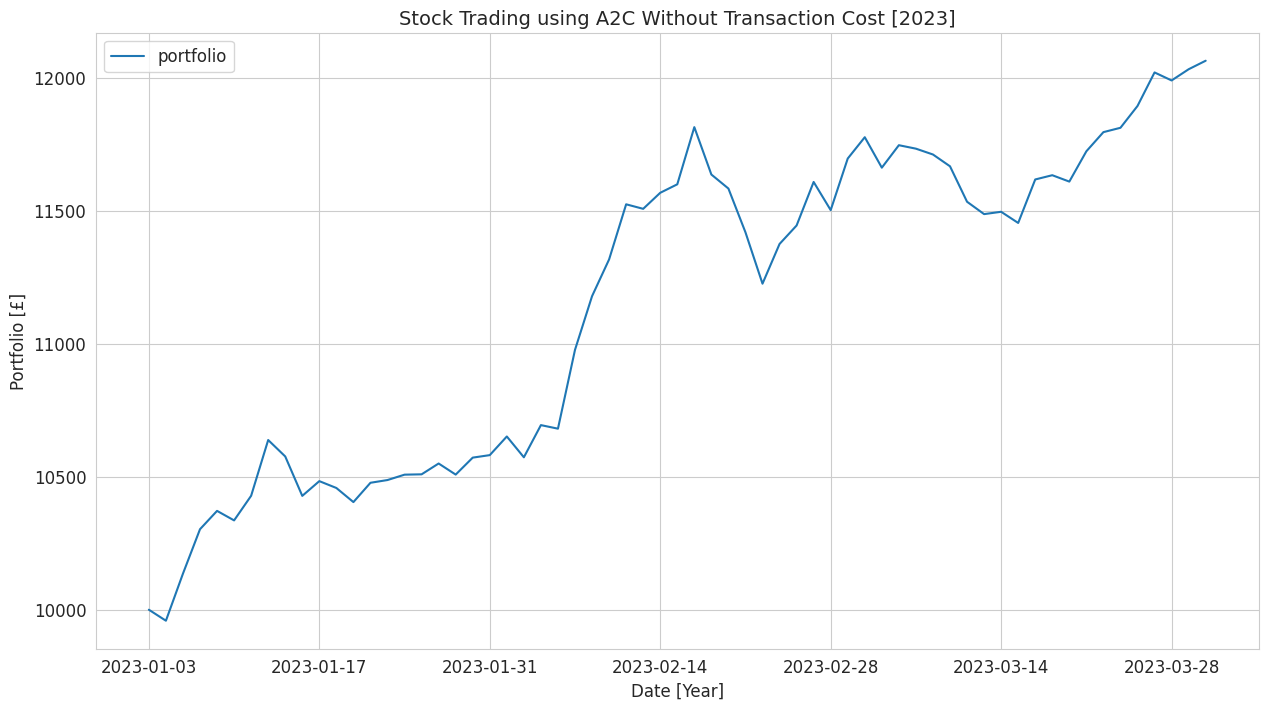

In [ ]:
trade_df_a2c = pd.read_csv('/content/trade_0_results')
trade_df_a2c = trade_df_a2c.drop('Unnamed: 0', axis=1).set_index('date')
trade_df_a2c.plot(kind = 'line', figsize=(15, 8),  fontsize=12)
plt.xlabel('Date [Year]', fontsize=12)
plt.ylabel('Portfolio [£]', fontsize=12)
plt.legend(fontsize=12)
plt.title('Stock Trading using A2C Without Transaction Cost [2023]', fontsize=14)
plt.show()

## PPO Model

In [ ]:
ppo_model = PPO('MlpPolicy', train_env, learning_rate=0.001, n_steps=2048, ent_coef=0.01, gamma=0.1 ,verbose=1, seed=10, batch_size=128)

Using cpu device


In [ ]:
ppo_model.learn(total_timesteps=30000, log_interval=10000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
mean_reward, _ = evaluate_policy(ppo_model, val_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}")

Mean reward: 28.685219789652184


In [ ]:
#Validation
val_return = render_trading(a2c_model, val_env, validation_data, n_episodes=100)

Average reward 43.46435546875
Average reward 48.86543655395508
Average reward 48.214534759521484
Average reward 47.61267852783203
Average reward 49.918235778808594
Average reward 50.42585372924805
Average reward 50.62372970581055
Average reward 50.63588333129883
Average reward 50.90386199951172
Average reward 50.37154769897461


In [ ]:
ppo_trade = render_trading(ppo_model, trade_env, trading_data, n_episodes=1)

Initial Portfolio Value : 10000 | Final Portfolio Value : 12279.270288418898 | Total rewards : 2279.2702884188984 | % of profit : 22.792702884188984


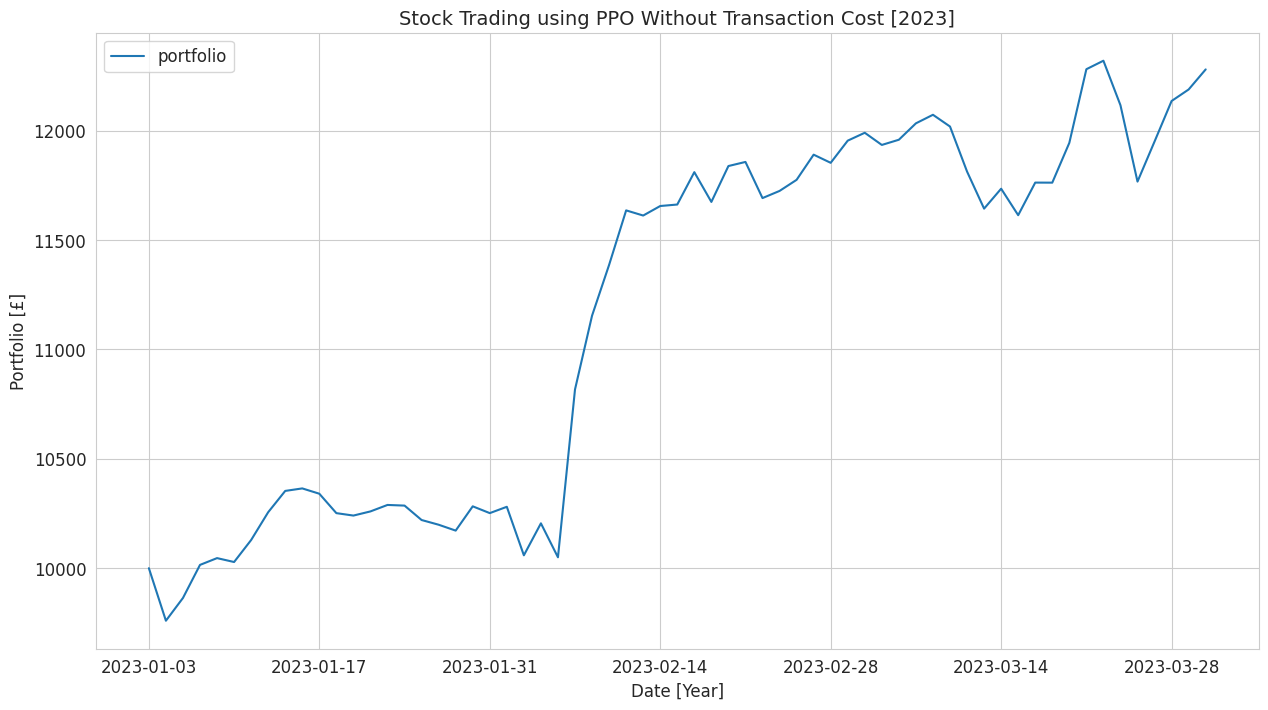

In [ ]:
trade_df_PPO = pd.read_csv('/content/trade_0_results')
trade_df_PPO = trade_df_PPO.drop('Unnamed: 0', axis=1).set_index('date')
trade_df_PPO.plot(kind = 'line', figsize=(15, 8),  fontsize=12)
plt.xlabel('Date [Year]', fontsize=12)
plt.ylabel('Portfolio [£]', fontsize=12)
plt.legend(fontsize=12)
plt.title('Stock Trading using PPO Without Transaction Cost [2023]', fontsize=14)
plt.show()